#**X-RayNet: Classification of COVID-19, Viral and Bacterial Pneumonia through Chest X-Rays using Deep CNN**

## **Index**
1) Importing required libraries

2) Preparing data

3) Data pre-processing

4) Balanced class weight estimation

5) Structural units - Identity mapping unit, Dimensional transformation unit

6) The model architecture

7) Training

8) Visualizing the model performance

9) ROC curve

10) Binary classification

11) Conclusion




## **1) Importing required libraries**

In [ ]:
import numpy as np # linear algebra
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import cv2
import random
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam

from scipy import interp


from sklearn.metrics import roc_curve, auc


## **2) Preparing data**

The dataset for classifying COVID-19, viral and bacterial pneumonia was built by assembling images from several public data sources. 

1) The normal, bacterial and viral pneumonia chest X-rays were collected from a Kaggle challenge (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) which included 5,863 X-Ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients (Age 1 to 5) from Guangzhou Women and Children’s Medical Center. These images segregated into pneumonia and normal classes. We further divided the pneumonia class of X-rays into viral and bacterial pneumonia based on the image name. 

2) The COVID-19 CXR dataset was collected from the public open repository of GitHub (https://github.com/ieee8023/covid-chestxray-dataset). As of November 29, 2020, this repository contained 782 images. In this public repository, 595 images are labeled as COVID-19 while the remaining images are from patients with pneumonia caused by other viral and bacterial agents. Unlike the previous dataset, these images were collected from various public sources, hence, they varied in size and quality. X-ray images included both frontal and side views. After excluding side view X-ray images, our primary COVID-19 dataset included 533 images. 

So totally our dataset comprised of 6,454 Chest Xray images images. 

We uploaded this dataset in Kaggle (https://www.kaggle.com/sriramthakur/classification-of-covid-viral-bacterial-pneumonia) and retrived it here. 

Google Drive and Kaggle Integration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Kaggle

In [ ]:
! pip install -q kaggle


Upgrading Kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=6c3bc4a308cb03ee54968c523c50308a3739826acd4010c86edcf3f78dd30ed3
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


Importing kaggle.json file

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivanisankar22","key":"e121f482d3c7871faa4277ae5af83ebd"}'}

Creating directory .kaggle

In [ ]:
 ! mkdir ~/.kaggle

copy kaggle.json in .kaggle folder

In [ ]:
! cp kaggle.json ~/.kaggle

Updating the permission on kaggle.json file

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

downloading the data set by executing the following code

In [ ]:
!kaggle datasets download classification-of-covid-viral-bacterial-pneumonia

create a new directory to unzip the data 

In [ ]:
! mkdir data

In [ ]:
! unzip /content/classification-of-covid-viral-bacterial-pneumonia.zip -d data

Archive:  /content/classification-of-covid-viral-bacterial-pneumonia.zip
replace data/Data/test/BACTERIAL/person100_bacteria_475.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **3) Data pre-processing**

Converting all images to numpy array to boost speed

In [ ]:
import glob
normal_cases = glob.glob ("/content/data/Data/val/NORMAL/*.jpeg")
bacterial_cases = glob.glob ("/content/data/Data/val/BACTERIAL/*.jpeg")
viral_cases = glob.glob ("/content/data/Data/val/VIRAL/*.jpeg")
covid_cases = glob.glob ("/content/data/Data/val/COVID/*.jpg")

In [ ]:
# Training data as a list
val_data = []
val_labels = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    # Convert grayscale image
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # CV2 uses BGR format, so we need to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalizing the pixel values by dividing by its maximum
    img = img.astype(np.float32)/255.
    val_data.append(img)
    val_labels.append(0)

# bacterial cases        
for img in bacterial_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    val_data.append(img)
    val_labels.append(1)

# viral cases        
for img in viral_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    val_data.append(img)
    val_labels.append(2)


# covid cases        
for img in covid_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    val_data.append(img)
    val_labels.append(3)

val_data = np.array(val_data)
val_labels = np.array(val_labels)

print("Total number of training examples: ", val_data.shape)
print("Total number of labels:", val_labels.shape)

Total number of training examples:  (966, 64, 64, 3)
Total number of labels: (966,)


In [ ]:
np.save('val_data.npy',val_data)
np.save('val_labels.npy',val_labels)

Creating Train Data Set

In [ ]:
normal_cases = glob.glob ("/content/data/Data/train/NORMAL/*.jpeg")
bacterial_cases = glob.glob ("/content/data/Data/train/BACTERIAL/*.jpeg")
viral_cases = glob.glob ("/content/data/Data/train/VIRAL/*.jpeg")
covid_cases = glob.glob ("/content/data/Data/train/COVID/*.jpg")

# Training data as a list
train_data = []
train_labels = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    # Convert grayscale image
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # CV2 uses BGR format, so we need to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalizing the pixel values by dividing by its maximum
    img = img.astype(np.float32)/255.
    train_data.append(img)
    train_labels.append(0)

# bacterial cases        
for img in bacterial_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    train_data.append(img)
    train_labels.append(1)

# viral cases        
for img in viral_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    train_data.append(img)
    train_labels.append(2)


# covid cases        
for img in covid_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    train_data.append(img)
    train_labels.append(3)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

print("Total number of training examples: ", train_data.shape)
print("Total number of labels:", train_labels.shape)

Total number of training examples:  (4512, 64, 64, 3)
Total number of labels: (4512,)


In [ ]:
np.save('train_data.npy',train_data)
np.save('train_labels.npy',train_labels)

In [ ]:
normal_cases = glob.glob ("/content/data/Data/test/NORMAL/*.jpeg")
bacterial_cases = glob.glob ("/content/data/Data/test/BACTERIAL/*.jpeg")
viral_cases = glob.glob ("/content/data/Data/test/VIRAL/*.jpeg")
covid_cases = glob.glob ("/content/data/Data/test/COVID/*.jpg")

# Training data as a list
test_data = []
test_labels = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    # Convert grayscale image
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    # CV2 uses BGR format, so we need to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalizing the pixel values by dividing by its maximum
    img = img.astype(np.float32)/255.
    test_data.append(img)
    test_labels.append(0)

# bacterial cases        
for img in bacterial_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    test_data.append(img)
    test_labels.append(1)

# viral cases        
for img in viral_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    test_data.append(img)
    test_labels.append(2)


# covid cases        
for img in covid_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (64,64))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    test_data.append(img)
    test_labels.append(3)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of training examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

np.save('test_data.npy',test_data) 
np.save('test_labels.npy',test_labels)

Total number of training examples:  (964, 64, 64, 3)
Total number of labels: (964,)


In [ ]:
train_dir = "/content/drive/My Drive/Project/Data/train"
test_dir = "/content/drive/My Drive/Project/Data/test"
val_dir = "/content/drive/My Drive/Project/Data/val"

print("Train set:\n========================================")
num_bacterial = len(os.listdir(os.path.join(train_dir, 'BACTERIAL')))
num_viral = len(os.listdir(os.path.join(train_dir, 'VIRAL')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_covid = len(os.listdir(os.path.join(train_dir, 'COVID')))
print(f"BACTERIAL={num_bacterial}")
print(f"VIRAL={num_viral}")
print(f"NORMAL={num_normal}")
print(f"COVID={num_covid}")

print("Test set:\n========================================")
print(f"BACTERIAL={len(os.listdir(os.path.join(test_dir, 'BACTERIAL')))}")
print(f"VIRAL={len(os.listdir(os.path.join(test_dir, 'VIRAL')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")
print(f"COVID={len(os.listdir(os.path.join(test_dir, 'COVID')))}")

print("Validation set:\n========================================")
print(f"BACTERIAL={len(os.listdir(os.path.join(val_dir, 'BACTERIAL')))}")
print(f"VIRAL={len(os.listdir(os.path.join(val_dir, 'VIRAL')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")
print(f"COVID={len(os.listdir(os.path.join(val_dir, 'COVID')))}")


Train set:
BACTERIAL=1947
VIRAL=1056
NORMAL=1109
COVID=404
Test set:
BACTERIAL=418
VIRAL=225
NORMAL=238
COVID=87
Validation set:
BACTERIAL=418
VIRAL=225
NORMAL=239
COVID=88


###Loading Training Files

In [ ]:
train_data=np.load('/content/drive/MyDrive/train_data.npy')
train_label=np.load('/content/drive/MyDrive/train_labels.npy')
train_label.shape, train_data.shape

((4512,), (4512, 64, 64, 3))

**Train Data Visualization**

100%|██████████| 3/3 [00:00<00:00, 192.87it/s]


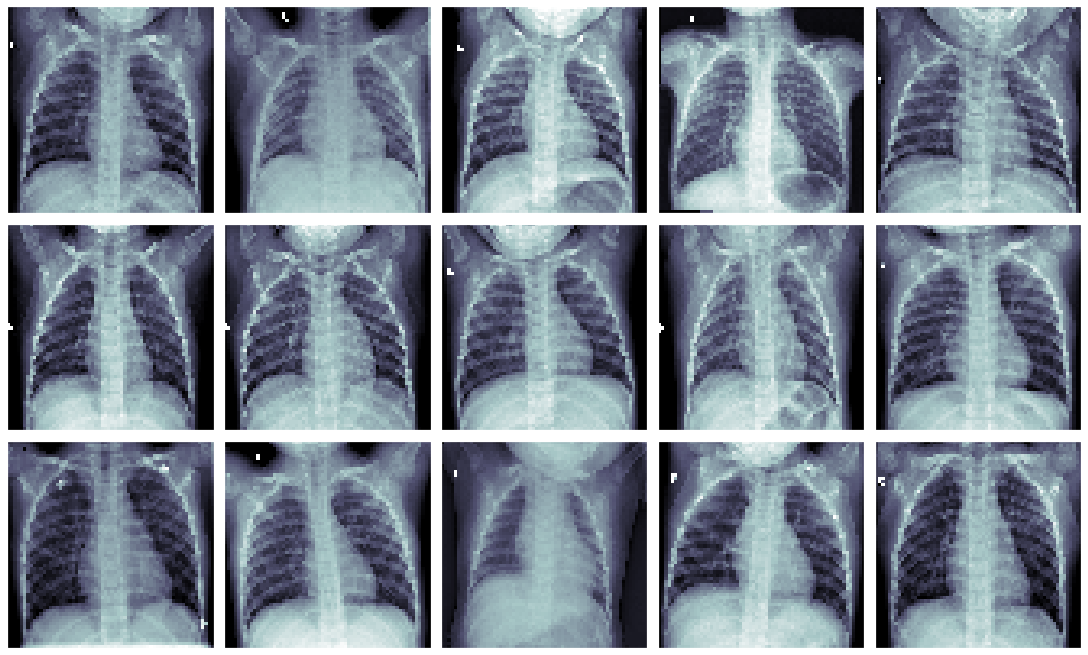

In [ ]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(train_data[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

### Loading Test Data

In [ ]:
test_data = np.load('/content/drive/MyDrive/test_data.npy')
test_label = np.load('/content/drive/MyDrive/test_labels.npy')
test_data.shape

(964, 64, 64, 3)

**Test Data Visualization**

100%|██████████| 3/3 [00:00<00:00, 227.68it/s]


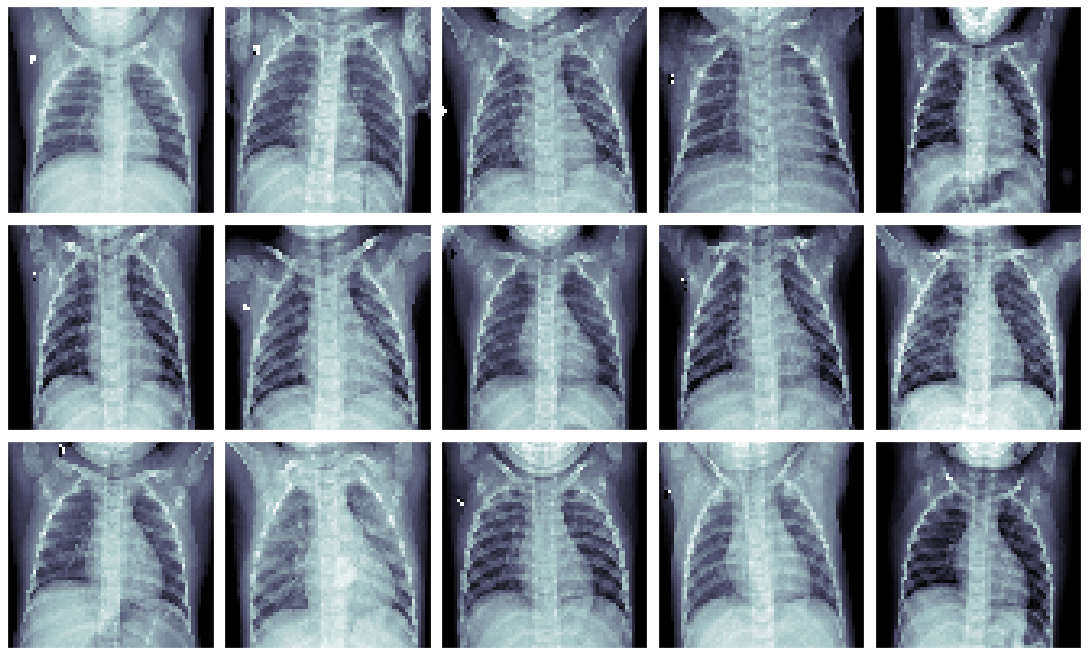

In [ ]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(test_data[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

###Loading Val Files

In [ ]:
val_data=np.load('/content/drive/MyDrive/val_data.npy')
val_labels=np.load('/content/drive/MyDrive/val_labels.npy')
val_data.shape

(966, 64, 64, 3)

**VAL Data Visualization**

100%|██████████| 3/3 [00:00<00:00, 217.33it/s]


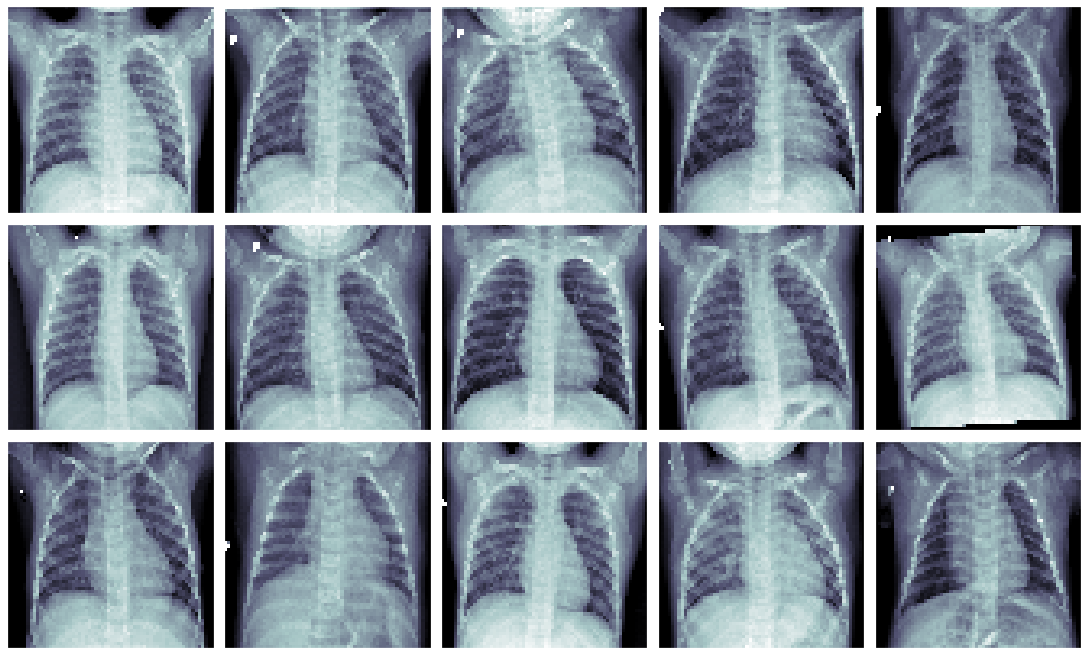

In [ ]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(val_data[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

One Hot Encoding the labels

In [ ]:
from keras.utils import to_categorical
train_label = to_categorical(train_label, num_classes= 4)
test_label  = to_categorical(test_label, num_classes = 4)
val_label = to_categorical(val_labels, num_classes = 4)

ImageDataGenerator

If we have less data, then we can use the ImageDataGenerator using some of the different parameters like - randomly rotate images in the range of 0 to 180 degress With data augmentation to prevent overfitting and handling the imbalance in dataset from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import *


train_datagen = ImageDataGenerator(rescale = 1/255,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'constant',
                                  zoom_range = 0.2,
                                  rotation_range = 30)

val_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow(train_data,
                                     train_label, 
                                     batch_size = 16, 
                                     shuffle = True)

val_generator = val_datagen.flow(test_data,
                                 test_label,
                                 batch_size = 16,
                                 shuffle = False)

val2_generator = val_datagen.flow(val_data,
                                val_label,
                                batch_size = 16,
                                shuffle = False)


**Vizualization After Augmentation**

In [ ]:
images, labels = train_generator.next()

100%|██████████| 3/3 [00:00<00:00, 175.85it/s]


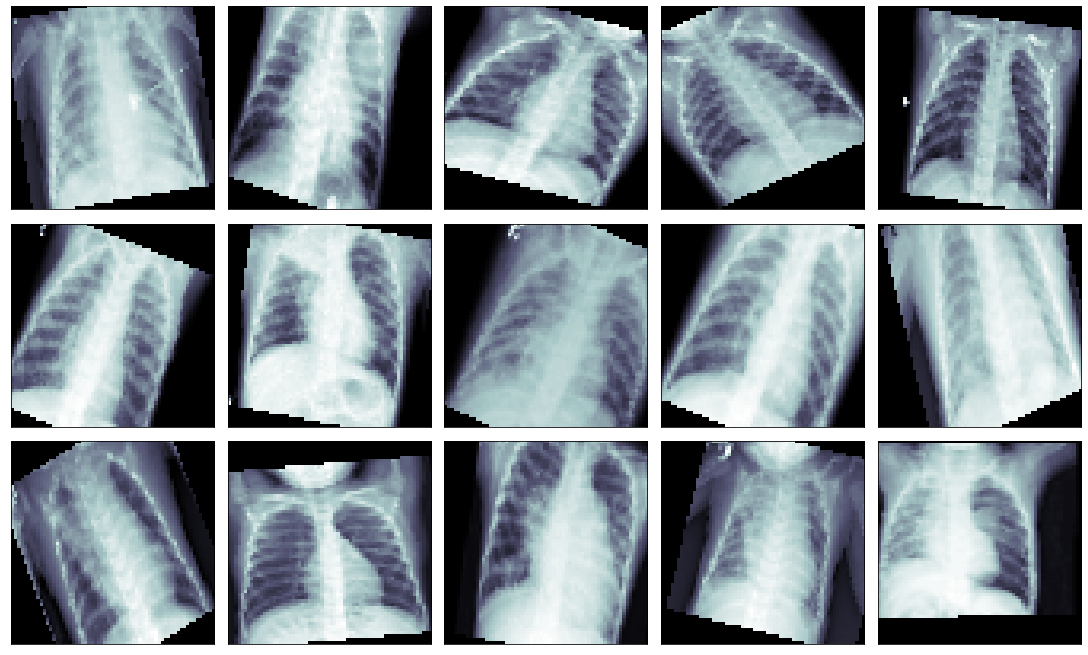

In [ ]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(images[row*n_col + col,:,:,0], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

## **4) Balanced class weight estimation**

In [ ]:
from sklearn.utils import class_weight
 
 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_label),
                                                 train_label)
class_weights

array([1.01805054, 0.57965057, 1.06919431, 2.79900744])

## **5) Structural units**
Our model is comprised of two main building blocks:

1. Identity mapping unit
 
2. Dimensional transformation unit

In both the blocks, Depthwise dilated convolutions are applied to effectively extract distinctive features from X-rays to identify pneumonia

### **i) Identity mapping unit**

This unit comprises of pointwise, depthwise and pointwise convolutional mapping. Firstly, the input shape of the image goes through a pointwise convolution ie., traditional convolution layer (Conv2D) and a batch normalization then through a depthwise convolutional layer with kernel (3,3), ReLu activation and with different dilation rates starting from dilation rate of 1 to a max-dilation rate of 5 followed by a batch normalization.

In [ ]:
def Identity_Unit(input_tensor, num_of_input_channels, max_dilation, number_of_units):
    
  for i in range(number_of_units):
    x1 = Conv2D(num_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)
  
    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)
    x = Conv2D(num_of_input_channels, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    x = Add()([x, input_tensor])

    input_tensor = x
  
  return x

### **ii) Dimentional transformation unit**

In this unit, the input feature map undergoes dimensional transformations. As part of the shift block there are multiple layers applied. At first Conv2D, batch normalization, then the iteration of Depthwise Conv2D, Maxpool2D and batch normalization layers with 6 dilations. Then we concatenate the iteration data and add Conv2D and batch normalization layers in the end. 

In [ ]:
# Dimentional transformation unit:

def Dimentional_Unit(input_tensor, num_of_input_channels, max_dilation):
    x1 = Conv2D(num_of_input_channels*4, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(input_tensor)
    x1 = BatchNormalization()(x1)

    a = []

    for i in range(1, max_dilation+1):
      temp = DepthwiseConv2D( kernel_size=(3,3), dilation_rate = (i,i), padding = 'same', activation= 'relu')(x1)
      temp = MaxPool2D(pool_size=(2,2))(temp)
      temp = BatchNormalization()(temp)
      a.append(temp)

    x = Concatenate(axis= -1)(a)

    x = Conv2D(num_of_input_channels*2, kernel_size = (1,1), strides = (1,1), padding='same', dilation_rate= (1,1), activation='relu')(x)
    x = BatchNormalization()(x)

    return x

## **6) The Model Architecture**

1) The input image undergoes convolutions with broader kernels to process the information with the larger receptive area. 

2) The following convolution introduces some dimensional transformation. 

3) It passes through a series of identity mapping units. Depth of this stack of residual learning can be increased to produce a deeper network. 

4) Dimentional transformation uunits are incorporated in between such stacks to introduce dimensional transformation to generalize the extracted information further. However, the maximum dilation rate of each residual unit is determined based on the dimension of the input feature map. 

5) Finally, the processed feature map passes through global average pooling followed by some densely connected layers before providing final prediction. 

6) Moreover, the rectified linear unit (Relu) is instigated after each convolution for non-linear activation with batch normalization to make the convergence faster.

In [ ]:
def ClsModel(input_shape, num_class, depth):
  xin = Input(shape= input_shape)

  x = Conv2D(16, kernel_size = (5,5), strides= (1,1), padding = 'same', activation='relu')(xin)
  x = BatchNormalization()(x)

  x = Conv2D(32, kernel_size = (3,3), strides= (2,2), padding = 'same', activation='relu')(x)
  x = BatchNormalization()(x)
  
##Max Dilation rate will be vary in the range (1,5). 

# Max Dilation rate is 5 for tensor (64x64x32)
  x = Identity_Unit(input_tensor=x, num_of_input_channels=32, max_dilation=5, number_of_units=depth)
  x = Dimentional_Unit(input_tensor=x, num_of_input_channels=32, max_dilation=5)


# Max Dilation rate is 4 for (32x32x64)
  x = Identity_Unit(input_tensor=x, num_of_input_channels=64, max_dilation=4, number_of_units=depth)
  x = Dimentional_Unit(input_tensor=x, num_of_input_channels=64, max_dilation=4)

# Max Dilation rate is 3 for (16x16x128)
  x = Identity_Unit(input_tensor=x, num_of_input_channels=128, max_dilation=3, number_of_units=depth)
  x = Dimentional_Unit(input_tensor=x, num_of_input_channels=128, max_dilation=3)

# Max Dilation rate is 2 for (8x8x256)
  x = Identity_Unit(input_tensor=x, num_of_input_channels=256, max_dilation=2, number_of_units=depth)

  x = GlobalAveragePooling2D()(x)

  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)

  x = Dense(num_class, activation= 'softmax')(x) 
  #Multi Class Prediction - So softmax classifier is used for normalizing the probability vector for any input

  model = Model(xin, x)

  model.compile(loss='categorical_crossentropy', optimizer = Adam(lr = 1e-3), metrics = ['accuracy'])

  return model

## **7) Model performance evaluation**

In [ ]:
# plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm
from sklearn import metrics
import seaborn as sns
sns.set()

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=False)
    if save == True:
      plt.savefig('Confusion Matrix.png', dpi = 900)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import sys


In [ ]:
# test model performance
from datetime import datetime
import matplotlib.pyplot as plt


def test_model(model, test_generator, y_test, class_labels, cm_normalize=True, \
                 print_cm=True):
    
    # BS = 16
    results = dict()
    
    # n = len(testy)// BS

    # testX = testX[:BS*n]
    # testy = testy[:BS*n]

    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred_original = model.predict_generator(test_generator,verbose=1)
    # y_pred = (y_pred_original>0.5).astype('int')

    y_pred = np.argmax(y_pred_original, axis = 1)
    # y_test = np.argmax(testy, axis= 1)
    #y_test = np.argmax(testy, axis=-1)
    
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    y_test = y_test.astype(int) # sparse form not categorical
    

    # balanced_accuracy
    from sklearn.metrics import balanced_accuracy_score
    balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    print('---------------------')
    print('| Balanced Accuracy  |')
    print('---------------------')
    print('\n    {}\n\n'.format(balanced_accuracy))

    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    

    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,4))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    plt.show()
    

    
    # add the trained  model to the results
    results['model'] = model
    
    return


from keras.callbacks import Callback
class MyLogger(Callback):
  
  def __init__(self, test_generator, y_test, class_labels):
    super(MyLogger, self).__init__()
    self.test_generator = test_generator
    self.y_test = y_test
    self.class_labels = class_labels
    
  def on_epoch_end(self, epoch, logs=None):
    test_model(self.model, self.test_generator, self.y_test, self.class_labels)

In [ ]:
if not os.path.exists('Model'):
  os.mkdir('Model')
if not os.path.exists('History'):
  os.mkdir('History')

In [ ]:
def get_callbacks():
    
    filepath = 'Model/best_model_multiclass_128.h5'
    callback1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callback2 = MyLogger(val_generator, 
                         y_test = np.argmax(test_label, axis = 1),
                         class_labels = ['Normal', 'Bacterial', 'Viral', 'COVID'])
    
    callback3 = CSVLogger('History/Multiclass_Log_128.csv')

    return [callback1 ,callback2, callback3]

## **8. Training**

Model Summary

In [ ]:
model = ClsModel(input_shape = (64, 64, 3), num_class = 4, depth = 5)
model.summary() 

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 64, 64, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_130 (BatchN (None, 64, 64, 16)   64          conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 32, 32, 32)   4640        batch_normalization_130[0][0]    
_______________________________________________________________________________________

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
282/282 [==============================] - ETA: 0s - loss: 0.4117 - accuracy: 0.7888
Epoch 00001: val_accuracy improved from -inf to 0.85417, saving model to Model/best_model_multiclass_128.h5
Predicting test data
Instructions for updating:
Please use Model.predict, which supports generators.
61/61 [==============================] - 2s 37ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:04.745156


---------------------
| Balanced Accuracy  |
---------------------

    0.8511110271020326


---------------------
|      Accuracy      |
---------------------

    0.8547717842323651


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       237
           1       0.82      0.93      0.87       417
           2       0.89      0.52      0.66       224
           3       0.98      0.

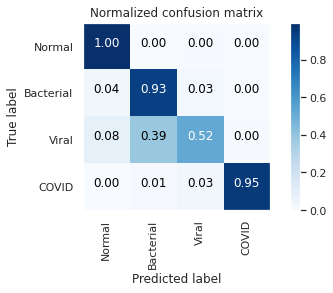

282/282 [==============================] - 59s 209ms/step - loss: 0.4117 - accuracy: 0.7888 - val_loss: 0.3892 - val_accuracy: 0.8542
Epoch 2/70
282/282 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.7985
Epoch 00002: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 36ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.221844


---------------------
| Balanced Accuracy  |
---------------------

    0.8213617575807725


---------------------
|      Accuracy      |
---------------------

    0.8246887966804979


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       237
           1       0.83      0.90      0.87       417
           2       0.83      0.46      0.59       224
           3       0.98      0.93      0.95        86

    accuracy                           0.82       9

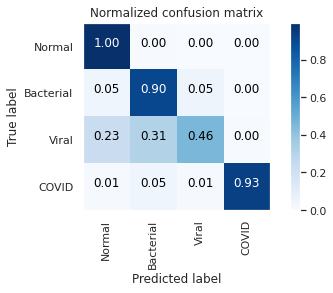

282/282 [==============================] - 52s 185ms/step - loss: 0.3951 - accuracy: 0.7985 - val_loss: 0.4468 - val_accuracy: 0.8240
Epoch 3/70
282/282 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8098
Epoch 00003: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.215527


---------------------
| Balanced Accuracy  |
---------------------

    0.860542463302162


---------------------
|      Accuracy      |
---------------------

    0.8454356846473029


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       237
           1       0.86      0.85      0.86       417
           2       0.77      0.64      0.70       224
           3       0.98      0.97      0.97        86

    accuracy                           0.85       96

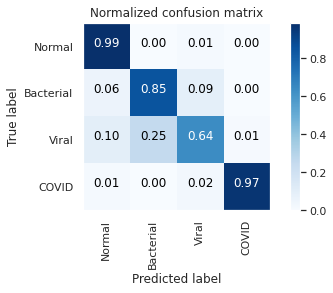

282/282 [==============================] - 52s 184ms/step - loss: 0.3731 - accuracy: 0.8098 - val_loss: 0.4409 - val_accuracy: 0.8448
Epoch 4/70
282/282 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8136
Epoch 00004: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.209490


---------------------
| Balanced Accuracy  |
---------------------

    0.8420944722627214


---------------------
|      Accuracy      |
---------------------

    0.8267634854771784


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       237
           1       0.85      0.83      0.84       417
           2       0.78      0.58      0.67       224
           3       0.98      0.95      0.96        86

    accuracy                           0.83       9

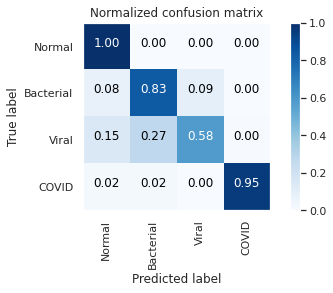

282/282 [==============================] - 52s 184ms/step - loss: 0.3601 - accuracy: 0.8136 - val_loss: 0.4866 - val_accuracy: 0.8260
Epoch 5/70
282/282 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8096
Epoch 00005: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.209212


---------------------
| Balanced Accuracy  |
---------------------

    0.7204545748783033


---------------------
|      Accuracy      |
---------------------

    0.7323651452282157


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       237
           1       0.80      0.89      0.85       417
           2       0.86      0.08      0.15       224
           3       0.96      0.91      0.93        86

    accuracy                           0.73       9

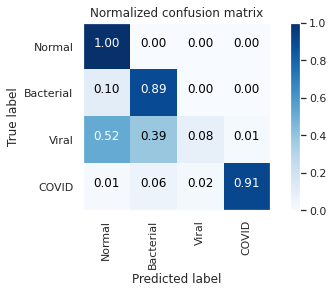

282/282 [==============================] - 52s 184ms/step - loss: 0.3838 - accuracy: 0.8096 - val_loss: 0.7020 - val_accuracy: 0.7323
Epoch 6/70
282/282 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8125
Epoch 00006: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.205265


---------------------
| Balanced Accuracy  |
---------------------

    0.7971163490902892


---------------------
|      Accuracy      |
---------------------

    0.7510373443983402


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       237
           1       0.85      0.66      0.74       417
           2       0.57      0.59      0.58       224
           3       0.82      0.94      0.88        86

    accuracy                           0.75       9

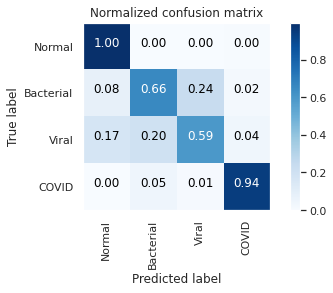

282/282 [==============================] - 52s 184ms/step - loss: 0.3635 - accuracy: 0.8125 - val_loss: 0.6148 - val_accuracy: 0.7500
Epoch 7/70
282/282 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.8165
Epoch 00007: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.199635


---------------------
| Balanced Accuracy  |
---------------------

    0.7972214421154107


---------------------
|      Accuracy      |
---------------------

    0.7759336099585062


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       237
           1       0.86      0.79      0.82       417
           2       0.75      0.45      0.56       224
           3       0.95      0.95      0.95        86

    accuracy                           0.78       9

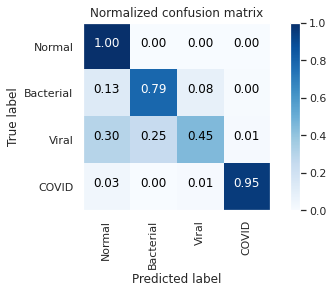

282/282 [==============================] - 52s 184ms/step - loss: 0.3691 - accuracy: 0.8165 - val_loss: 0.5988 - val_accuracy: 0.7750
Epoch 8/70
282/282 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8200
Epoch 00008: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.199275


---------------------
| Balanced Accuracy  |
---------------------

    0.8576870509774106


---------------------
|      Accuracy      |
---------------------

    0.8298755186721992


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       237
           1       0.87      0.79      0.82       417
           2       0.68      0.69      0.69       224
           3       0.98      0.97      0.97        86

    accuracy                           0.83       9

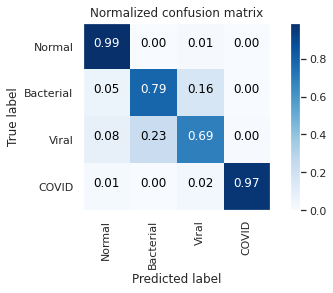

282/282 [==============================] - 52s 183ms/step - loss: 0.3506 - accuracy: 0.8200 - val_loss: 0.4184 - val_accuracy: 0.8292
Epoch 9/70
282/282 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.8090
Epoch 00009: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.201373


---------------------
| Balanced Accuracy  |
---------------------

    0.8294372599926703


---------------------
|      Accuracy      |
---------------------

    0.83298755186722


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       237
           1       0.82      0.92      0.86       417
           2       0.88      0.46      0.60       224
           3       0.98      0.94      0.96        86

    accuracy                           0.83       964

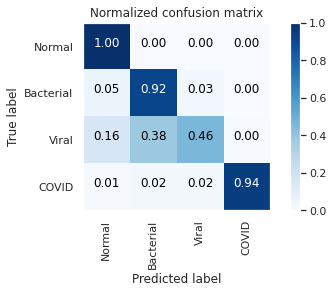

282/282 [==============================] - 52s 184ms/step - loss: 0.3530 - accuracy: 0.8090 - val_loss: 0.4713 - val_accuracy: 0.8323
Epoch 10/70
282/282 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8262
Epoch 00010: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.198177


---------------------
| Balanced Accuracy  |
---------------------

    0.7865414893998423


---------------------
|      Accuracy      |
---------------------

    0.8163900414937759


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.85       237
           1       0.82      0.90      0.86       417
           2       0.89      0.49      0.63       224
           3       0.98      0.76      0.86        86

    accuracy                           0.82       

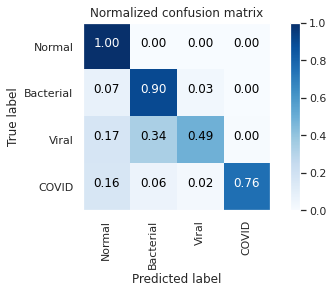

282/282 [==============================] - 52s 183ms/step - loss: 0.3442 - accuracy: 0.8262 - val_loss: 0.5192 - val_accuracy: 0.8156
Epoch 11/70
282/282 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8123
Epoch 00011: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.451765


---------------------
| Balanced Accuracy  |
---------------------

    0.801825711357824


---------------------
|      Accuracy      |
---------------------

    0.7904564315352697


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       237
           1       0.87      0.80      0.83       417
           2       0.77      0.51      0.61       224
           3       0.97      0.90      0.93        86

    accuracy                           0.79       9

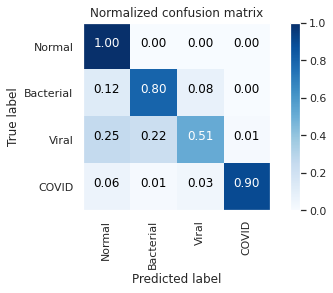

282/282 [==============================] - 52s 184ms/step - loss: 0.3720 - accuracy: 0.8123 - val_loss: 0.6023 - val_accuracy: 0.7896
Epoch 12/70
282/282 [==============================] - ETA: 0s - loss: 0.3462 - accuracy: 0.8211
Epoch 00012: val_accuracy did not improve from 0.85417
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.202955


---------------------
| Balanced Accuracy  |
---------------------

    0.8527326050657014


---------------------
|      Accuracy      |
---------------------

    0.8226141078838174


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       237
           1       0.86      0.76      0.81       417
           2       0.63      0.70      0.67       224
           3       0.98      0.95      0.96        86

    accuracy                           0.82       

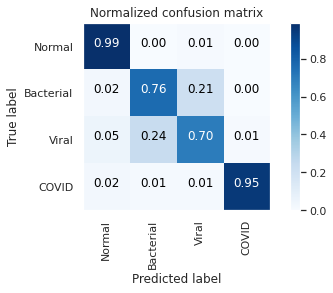

282/282 [==============================] - 52s 183ms/step - loss: 0.3462 - accuracy: 0.8211 - val_loss: 0.4102 - val_accuracy: 0.8219
Epoch 13/70
282/282 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8160
Epoch 00013: val_accuracy improved from 0.85417 to 0.85833, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.201461


---------------------
| Balanced Accuracy  |
---------------------

    0.8663584156435313


---------------------
|      Accuracy      |
---------------------

    0.8589211618257261


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       237
           1       0.83      0.91      0.87       417
           2       0.77      0.59      0.67       224
           3       0.96      0.99      0.97      

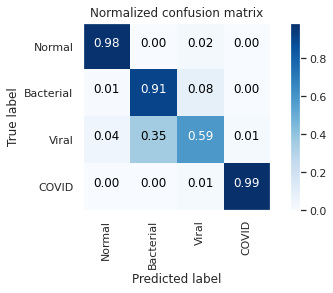

282/282 [==============================] - 53s 188ms/step - loss: 0.3650 - accuracy: 0.8160 - val_loss: 0.3536 - val_accuracy: 0.8583
Epoch 14/70
282/282 [==============================] - ETA: 0s - loss: 0.3337 - accuracy: 0.8227
Epoch 00014: val_accuracy did not improve from 0.85833
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.190244


---------------------
| Balanced Accuracy  |
---------------------

    0.8338168130914336


---------------------
|      Accuracy      |
---------------------

    0.7946058091286307


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       237
           1       0.87      0.69      0.77       417
           2       0.59      0.74      0.66       224
           3       0.96      0.92      0.94        86

    accuracy                           0.79       

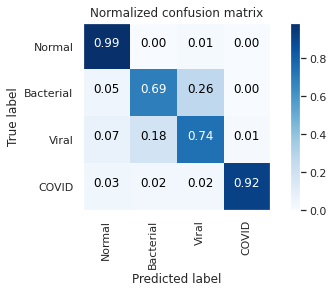

282/282 [==============================] - 52s 183ms/step - loss: 0.3337 - accuracy: 0.8227 - val_loss: 0.5018 - val_accuracy: 0.7937
Epoch 15/70
282/282 [==============================] - ETA: 0s - loss: 0.3381 - accuracy: 0.8180
Epoch 00015: val_accuracy did not improve from 0.85833
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.202391


---------------------
| Balanced Accuracy  |
---------------------

    0.8417251248834818


---------------------
|      Accuracy      |
---------------------

    0.8350622406639004


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       237
           1       0.84      0.88      0.86       417
           2       0.85      0.54      0.66       224
           3       0.98      0.95      0.96        86

    accuracy                           0.84       

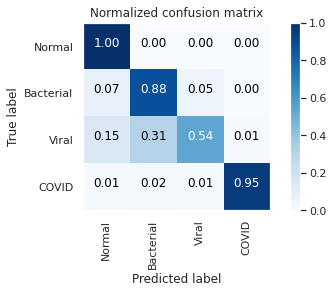

282/282 [==============================] - 52s 184ms/step - loss: 0.3381 - accuracy: 0.8180 - val_loss: 0.4569 - val_accuracy: 0.8344
Epoch 16/70
282/282 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.8349
Epoch 00016: val_accuracy did not improve from 0.85833
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.197997


---------------------
| Balanced Accuracy  |
---------------------

    0.8111086919500944


---------------------
|      Accuracy      |
---------------------

    0.8070539419087137


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       237
           1       0.86      0.86      0.86       417
           2       0.80      0.45      0.58       224
           3       0.95      0.93      0.94        86

    accuracy                           0.81       

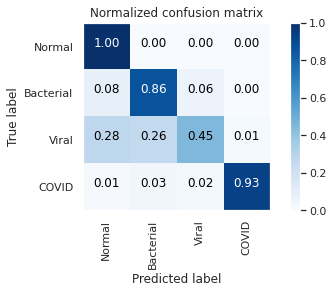

282/282 [==============================] - 52s 183ms/step - loss: 0.3221 - accuracy: 0.8349 - val_loss: 0.5584 - val_accuracy: 0.8062
Epoch 17/70
282/282 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8265
Epoch 00017: val_accuracy did not improve from 0.85833
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.193124


---------------------
| Balanced Accuracy  |
---------------------

    0.8174094169615735


---------------------
|      Accuracy      |
---------------------

    0.7821576763485477


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       237
           1       0.84      0.73      0.78       417
           2       0.60      0.59      0.60       224
           3       0.92      0.95      0.94        86

    accuracy                           0.78       

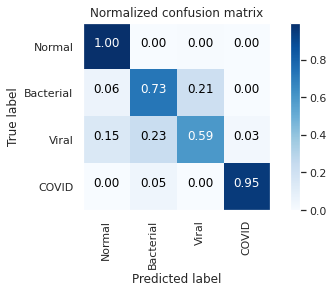

282/282 [==============================] - 52s 183ms/step - loss: 0.3376 - accuracy: 0.8265 - val_loss: 0.4843 - val_accuracy: 0.7812
Epoch 18/70
282/282 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8236
Epoch 00018: val_accuracy improved from 0.85833 to 0.86979, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.188550


---------------------
| Balanced Accuracy  |
---------------------

    0.8776596941253507


---------------------
|      Accuracy      |
---------------------

    0.8703319502074689


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       237
           1       0.85      0.92      0.88       417
           2       0.85      0.60      0.70       224
           3       0.83      1.00      0.91      

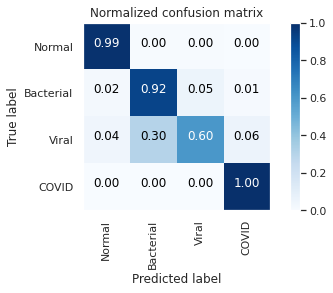

282/282 [==============================] - 53s 187ms/step - loss: 0.3532 - accuracy: 0.8236 - val_loss: 0.3958 - val_accuracy: 0.8698
Epoch 19/70
282/282 [==============================] - ETA: 0s - loss: 0.3201 - accuracy: 0.8333
Epoch 00019: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.206301


---------------------
| Balanced Accuracy  |
---------------------

    0.8432049489513902


---------------------
|      Accuracy      |
---------------------

    0.8184647302904564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       237
           1       0.88      0.74      0.80       417
           2       0.65      0.76      0.70       224
           3       0.99      0.88      0.93        86

    accuracy                           0.82       

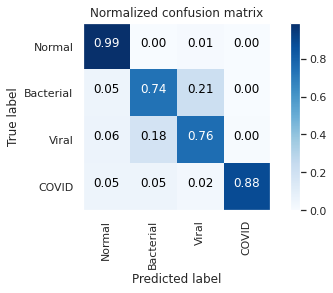

282/282 [==============================] - 52s 183ms/step - loss: 0.3201 - accuracy: 0.8333 - val_loss: 0.4620 - val_accuracy: 0.8177
Epoch 20/70
282/282 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8311
Epoch 00020: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.196519


---------------------
| Balanced Accuracy  |
---------------------

    0.8553427336246147


---------------------
|      Accuracy      |
---------------------

    0.8350622406639004


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       237
           1       0.86      0.81      0.83       417
           2       0.66      0.70      0.68       224
           3       0.98      0.94      0.96        86

    accuracy                           0.84       

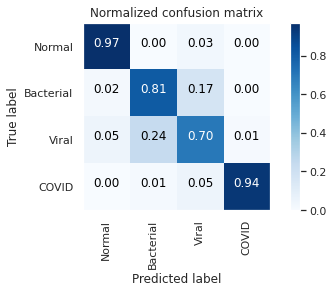

282/282 [==============================] - 52s 183ms/step - loss: 0.3177 - accuracy: 0.8311 - val_loss: 0.4072 - val_accuracy: 0.8344
Epoch 21/70
282/282 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8278
Epoch 00021: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.206720


---------------------
| Balanced Accuracy  |
---------------------

    0.8704604354491091


---------------------
|      Accuracy      |
---------------------

    0.8392116182572614


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       237
           1       0.86      0.80      0.83       417
           2       0.69      0.69      0.69       224
           3       0.98      1.00      0.99        86

    accuracy                           0.84       

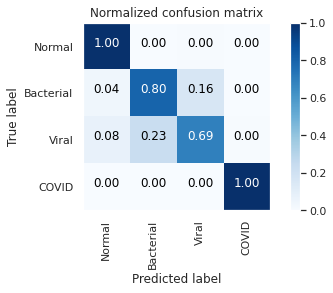

282/282 [==============================] - 52s 183ms/step - loss: 0.3134 - accuracy: 0.8278 - val_loss: 0.4028 - val_accuracy: 0.8385
Epoch 22/70
282/282 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8293
Epoch 00022: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.186417


---------------------
| Balanced Accuracy  |
---------------------

    0.8305075973179991


---------------------
|      Accuracy      |
---------------------

    0.8278008298755186


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.84      0.98      0.91       237
           1       0.81      0.91      0.86       417
           2       0.86      0.45      0.59       224
           3       0.84      0.98      0.90        86

    accuracy                           0.83       

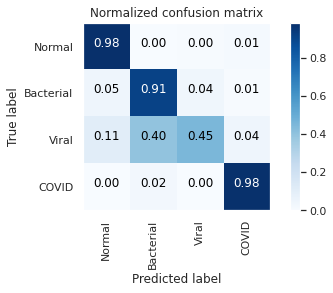

282/282 [==============================] - 52s 183ms/step - loss: 0.3357 - accuracy: 0.8293 - val_loss: 0.5056 - val_accuracy: 0.8271
Epoch 23/70
282/282 [==============================] - ETA: 0s - loss: 0.3232 - accuracy: 0.8353
Epoch 00023: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.191098


---------------------
| Balanced Accuracy  |
---------------------

    0.8235127637092983


---------------------
|      Accuracy      |
---------------------

    0.7821576763485477


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       237
           1       0.87      0.71      0.78       417
           2       0.59      0.60      0.60       224
           3       0.97      0.98      0.97        86

    accuracy                           0.78       

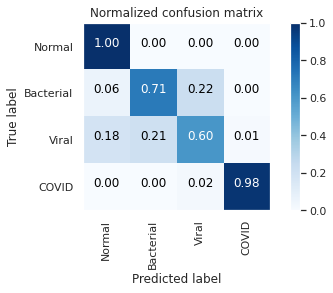

282/282 [==============================] - 51s 182ms/step - loss: 0.3232 - accuracy: 0.8353 - val_loss: 0.5005 - val_accuracy: 0.7812
Epoch 24/70
282/282 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8375
Epoch 00024: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.186485


---------------------
| Balanced Accuracy  |
---------------------

    0.8535377055498459


---------------------
|      Accuracy      |
---------------------

    0.8350622406639004


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       237
           1       0.88      0.86      0.87       417
           2       0.82      0.56      0.66       224
           3       0.90      1.00      0.95        86

    accuracy                           0.84       

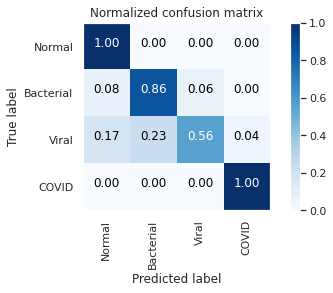

282/282 [==============================] - 52s 183ms/step - loss: 0.3050 - accuracy: 0.8375 - val_loss: 0.5584 - val_accuracy: 0.8344
Epoch 25/70
282/282 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8333
Epoch 00025: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.197902


---------------------
| Balanced Accuracy  |
---------------------

    0.7965619198992965


---------------------
|      Accuracy      |
---------------------

    0.783195020746888


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       237
           1       0.85      0.80      0.83       417
           2       0.67      0.46      0.55       224
           3       0.96      0.92      0.94        86

    accuracy                           0.78       9

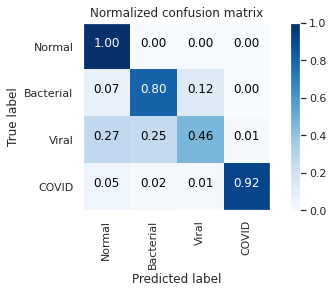

282/282 [==============================] - 51s 182ms/step - loss: 0.3181 - accuracy: 0.8333 - val_loss: 0.5404 - val_accuracy: 0.7823
Epoch 26/70
282/282 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8433
Epoch 00026: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.202910


---------------------
| Balanced Accuracy  |
---------------------

    0.8264320022387406


---------------------
|      Accuracy      |
---------------------

    0.8246887966804979


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       237
           1       0.81      0.90      0.85       417
           2       0.83      0.46      0.59       224
           3       0.98      0.95      0.96        86

    accuracy                           0.82       

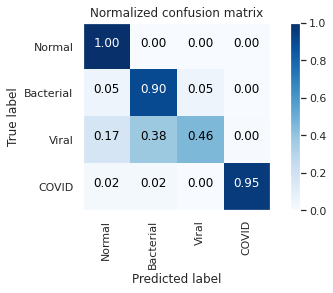

282/282 [==============================] - 51s 182ms/step - loss: 0.3041 - accuracy: 0.8433 - val_loss: 0.5302 - val_accuracy: 0.8240
Epoch 27/70
282/282 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8449
Epoch 00027: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.188653


---------------------
| Balanced Accuracy  |
---------------------

    0.7979414018618991


---------------------
|      Accuracy      |
---------------------

    0.7655601659751037


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       237
           1       0.87      0.73      0.80       417
           2       0.68      0.50      0.58       224
           3       0.94      0.95      0.95        86

    accuracy                           0.77       

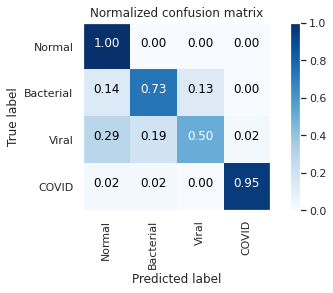

282/282 [==============================] - 52s 183ms/step - loss: 0.2896 - accuracy: 0.8449 - val_loss: 0.8441 - val_accuracy: 0.7646
Epoch 28/70
282/282 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8387
Epoch 00028: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.188336


---------------------
| Balanced Accuracy  |
---------------------

    0.842049346403276


---------------------
|      Accuracy      |
---------------------

    0.8360995850622407


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       237
           1       0.82      0.89      0.86       417
           2       0.85      0.51      0.64       224
           3       0.94      0.97      0.95        86

    accuracy                           0.84       9

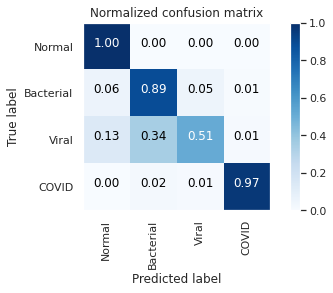

282/282 [==============================] - 51s 182ms/step - loss: 0.3038 - accuracy: 0.8387 - val_loss: 0.5352 - val_accuracy: 0.8354
Epoch 29/70
282/282 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8362
Epoch 00029: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.191307


---------------------
| Balanced Accuracy  |
---------------------

    0.8194526536346934


---------------------
|      Accuracy      |
---------------------

    0.7728215767634855


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       237
           1       0.86      0.70      0.77       417
           2       0.56      0.60      0.58       224
           3       0.91      0.99      0.95        86

    accuracy                           0.77       

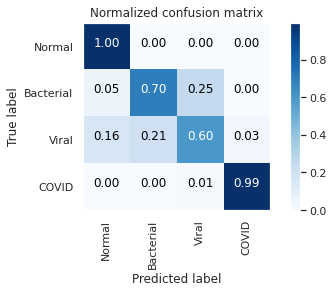

282/282 [==============================] - 51s 182ms/step - loss: 0.3030 - accuracy: 0.8362 - val_loss: 0.5658 - val_accuracy: 0.7719
Epoch 30/70
282/282 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8338
Epoch 00030: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.191084


---------------------
| Balanced Accuracy  |
---------------------

    0.824127969219309


---------------------
|      Accuracy      |
---------------------

    0.8122406639004149


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      1.00      0.87       237
           1       0.84      0.85      0.85       417
           2       0.73      0.48      0.58       224
           3       0.98      0.97      0.97        86

    accuracy                           0.81       9

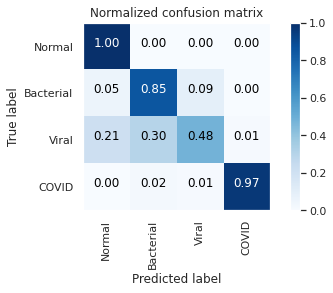

282/282 [==============================] - 51s 182ms/step - loss: 0.3138 - accuracy: 0.8338 - val_loss: 0.4844 - val_accuracy: 0.8115
Epoch 31/70
282/282 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8444
Epoch 00031: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.201030


---------------------
| Balanced Accuracy  |
---------------------

    0.801825711357824


---------------------
|      Accuracy      |
---------------------

    0.7904564315352697


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       237
           1       0.83      0.80      0.82       417
           2       0.75      0.51      0.61       224
           3       0.99      0.90      0.94        86

    accuracy                           0.79       9

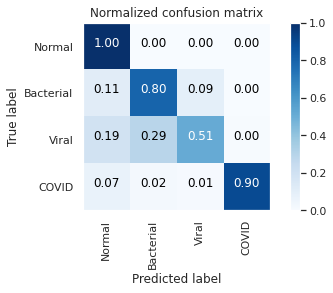

282/282 [==============================] - 52s 183ms/step - loss: 0.2950 - accuracy: 0.8444 - val_loss: 0.6191 - val_accuracy: 0.7896
Epoch 32/70
282/282 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8355
Epoch 00032: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.180509


---------------------
| Balanced Accuracy  |
---------------------

    0.861180670985311


---------------------
|      Accuracy      |
---------------------

    0.8423236514522822


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       237
           1       0.87      0.81      0.84       417
           2       0.70      0.72      0.71       224
           3       0.99      0.93      0.96        86

    accuracy                           0.84       9

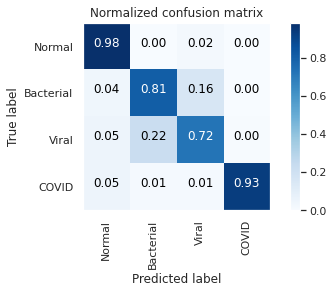

282/282 [==============================] - 51s 181ms/step - loss: 0.3026 - accuracy: 0.8355 - val_loss: 0.4450 - val_accuracy: 0.8417
Epoch 33/70
282/282 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8508
Epoch 00033: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.197458


---------------------
| Balanced Accuracy  |
---------------------

    0.8727372960435638


---------------------
|      Accuracy      |
---------------------

    0.8516597510373444


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       237
           1       0.87      0.82      0.85       417
           2       0.71      0.70      0.71       224
           3       0.97      0.97      0.97        86

    accuracy                           0.85       

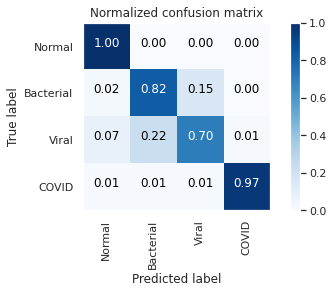

282/282 [==============================] - 51s 180ms/step - loss: 0.2843 - accuracy: 0.8508 - val_loss: 0.4028 - val_accuracy: 0.8510
Epoch 34/70
282/282 [==============================] - ETA: 0s - loss: 0.3006 - accuracy: 0.8431
Epoch 00034: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.179861


---------------------
| Balanced Accuracy  |
---------------------

    0.8362881746098139


---------------------
|      Accuracy      |
---------------------

    0.8278008298755186


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       237
           1       0.85      0.84      0.85       417
           2       0.77      0.58      0.66       224
           3       0.94      0.92      0.93        86

    accuracy                           0.83       

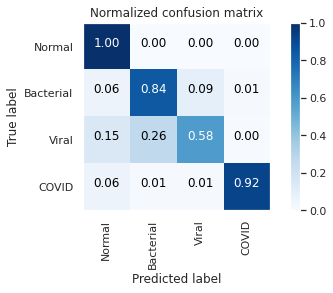

282/282 [==============================] - 51s 180ms/step - loss: 0.3006 - accuracy: 0.8431 - val_loss: 0.5025 - val_accuracy: 0.8271
Epoch 35/70
282/282 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8533
Epoch 00035: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.183843


---------------------
| Balanced Accuracy  |
---------------------

    0.8652864537084743


---------------------
|      Accuracy      |
---------------------

    0.8526970954356846


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       237
           1       0.84      0.88      0.86       417
           2       0.74      0.64      0.69       224
           3       0.95      0.98      0.97        86

    accuracy                           0.85       

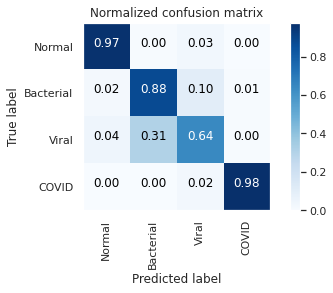

282/282 [==============================] - 51s 181ms/step - loss: 0.2792 - accuracy: 0.8533 - val_loss: 0.4295 - val_accuracy: 0.8521
Epoch 36/70
282/282 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.8537
Epoch 00036: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 36ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.234994


---------------------
| Balanced Accuracy  |
---------------------

    0.8472760759599562


---------------------
|      Accuracy      |
---------------------

    0.8360995850622407


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       237
           1       0.83      0.87      0.85       417
           2       0.80      0.56      0.66       224
           3       0.93      0.97      0.95        86

    accuracy                           0.84       

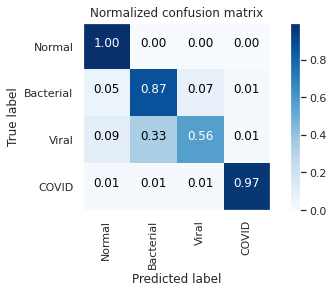

282/282 [==============================] - 52s 185ms/step - loss: 0.2741 - accuracy: 0.8537 - val_loss: 0.5014 - val_accuracy: 0.8354
Epoch 37/70
282/282 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8493
Epoch 00037: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.212192


---------------------
| Balanced Accuracy  |
---------------------

    0.8200380804108133


---------------------
|      Accuracy      |
---------------------

    0.7531120331950207


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       237
           1       0.89      0.60      0.71       417
           2       0.53      0.74      0.61       224
           3       0.68      0.99      0.81        86

    accuracy                           0.75       

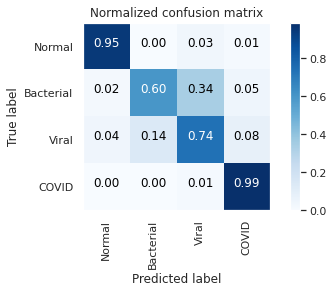

282/282 [==============================] - 52s 185ms/step - loss: 0.3015 - accuracy: 0.8493 - val_loss: 0.6355 - val_accuracy: 0.7521
Epoch 38/70
282/282 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8520
Epoch 00038: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.208230


---------------------
| Balanced Accuracy  |
---------------------

    0.8335781404314287


---------------------
|      Accuracy      |
---------------------

    0.7966804979253111


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       237
           1       0.87      0.74      0.80       417
           2       0.64      0.62      0.63       224
           3       0.89      0.98      0.93        86

    accuracy                           0.80       

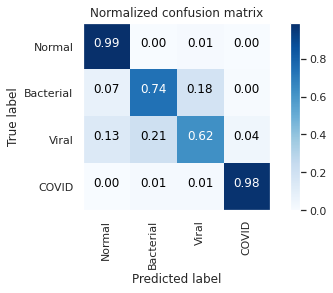

282/282 [==============================] - 52s 184ms/step - loss: 0.2835 - accuracy: 0.8520 - val_loss: 0.5311 - val_accuracy: 0.7958
Epoch 39/70
282/282 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8497
Epoch 00039: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.207517


---------------------
| Balanced Accuracy  |
---------------------

    0.604246545150019


---------------------
|      Accuracy      |
---------------------

    0.6130705394190872


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.31      0.46       237
           1       0.71      0.87      0.78       417
           2       0.29      0.36      0.32       224
           3       0.75      0.88      0.81        86

    accuracy                           0.61       9

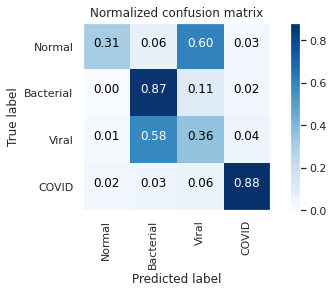

282/282 [==============================] - 52s 184ms/step - loss: 0.2830 - accuracy: 0.8497 - val_loss: 1.1810 - val_accuracy: 0.6125
Epoch 40/70
282/282 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8602
Epoch 00040: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 36ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.554113


---------------------
| Balanced Accuracy  |
---------------------

    0.8401871599570505


---------------------
|      Accuracy      |
---------------------

    0.8184647302904564


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.92       237
           1       0.84      0.80      0.82       417
           2       0.67      0.62      0.65       224
           3       0.87      0.95      0.91        86

    accuracy                           0.82       

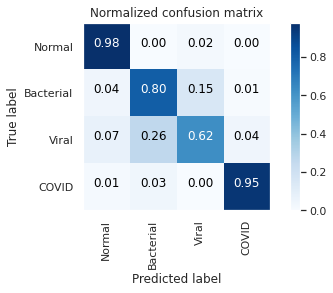

282/282 [==============================] - 53s 188ms/step - loss: 0.2678 - accuracy: 0.8602 - val_loss: 0.4851 - val_accuracy: 0.8177
Epoch 41/70
282/282 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.8621
Epoch 00041: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.221318


---------------------
| Balanced Accuracy  |
---------------------

    0.8282718924528152


---------------------
|      Accuracy      |
---------------------

    0.808091286307054


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       237
           1       0.86      0.77      0.81       417
           2       0.68      0.63      0.66       224
           3       0.99      0.91      0.95        86

    accuracy                           0.81       9

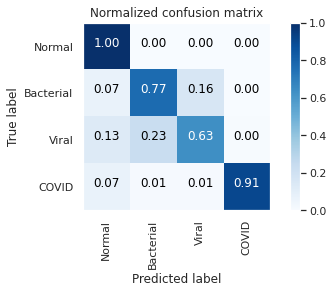

282/282 [==============================] - 52s 186ms/step - loss: 0.2669 - accuracy: 0.8621 - val_loss: 0.5604 - val_accuracy: 0.8073
Epoch 42/70
282/282 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.8637
Epoch 00042: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.221104


---------------------
| Balanced Accuracy  |
---------------------

    0.8282229075543551


---------------------
|      Accuracy      |
---------------------

    0.8246887966804979


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       237
           1       0.83      0.90      0.86       417
           2       0.87      0.45      0.59       224
           3       0.99      0.97      0.98        86

    accuracy                           0.82       

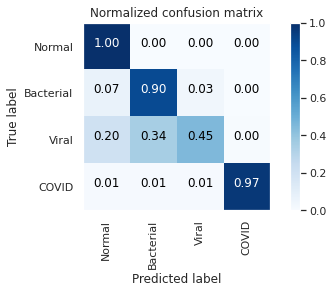

282/282 [==============================] - 53s 186ms/step - loss: 0.2492 - accuracy: 0.8637 - val_loss: 0.5863 - val_accuracy: 0.8240
Epoch 43/70
282/282 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8613
Epoch 00043: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 36ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.227839


---------------------
| Balanced Accuracy  |
---------------------

    0.8522140551678259


---------------------
|      Accuracy      |
---------------------

    0.8112033195020747


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       237
           1       0.88      0.71      0.79       417
           2       0.61      0.75      0.67       224
           3       0.96      0.95      0.96        86

    accuracy                           0.81       

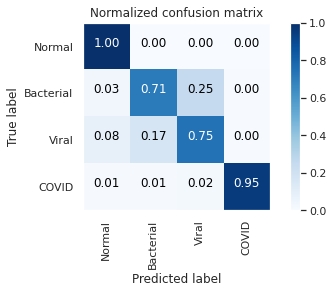

282/282 [==============================] - 52s 185ms/step - loss: 0.2675 - accuracy: 0.8613 - val_loss: 0.5065 - val_accuracy: 0.8104
Epoch 44/70
282/282 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8469
Epoch 00044: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.209112


---------------------
| Balanced Accuracy  |
---------------------

    0.8465068201021839


---------------------
|      Accuracy      |
---------------------

    0.8226141078838174


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       237
           1       0.86      0.78      0.82       417
           2       0.68      0.68      0.68       224
           3       0.95      0.93      0.94        86

    accuracy                           0.82       

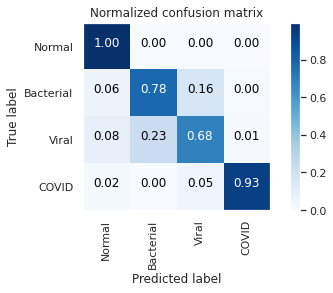

282/282 [==============================] - 52s 185ms/step - loss: 0.2848 - accuracy: 0.8469 - val_loss: 0.4876 - val_accuracy: 0.8219
Epoch 45/70
282/282 [==============================] - ETA: 0s - loss: 0.2831 - accuracy: 0.8497
Epoch 00045: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.200467


---------------------
| Balanced Accuracy  |
---------------------

    0.8470666368204902


---------------------
|      Accuracy      |
---------------------

    0.8319502074688797


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       237
           1       0.82      0.85      0.83       417
           2       0.70      0.59      0.64       224
           3       0.97      0.97      0.97        86

    accuracy                           0.83       

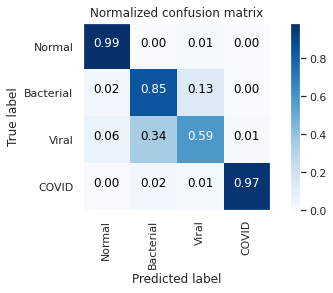

282/282 [==============================] - 52s 184ms/step - loss: 0.2831 - accuracy: 0.8497 - val_loss: 0.4834 - val_accuracy: 0.8313
Epoch 46/70
282/282 [==============================] - ETA: 0s - loss: 0.2586 - accuracy: 0.8559
Epoch 00046: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.212658


---------------------
| Balanced Accuracy  |
---------------------

    0.8415934062224967


---------------------
|      Accuracy      |
---------------------

    0.8205394190871369


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       237
           1       0.82      0.83      0.83       417
           2       0.69      0.57      0.62       224
           3       0.85      0.99      0.91        86

    accuracy                           0.82       

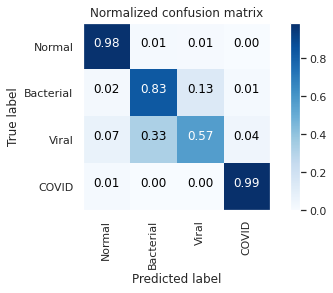

282/282 [==============================] - 52s 184ms/step - loss: 0.2586 - accuracy: 0.8559 - val_loss: 0.5062 - val_accuracy: 0.8198
Epoch 47/70
282/282 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8624
Epoch 00047: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.191694


---------------------
| Balanced Accuracy  |
---------------------

    0.8552086072006182


---------------------
|      Accuracy      |
---------------------

    0.8516597510373444


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       237
           1       0.83      0.89      0.86       417
           2       0.83      0.59      0.69       224
           3       0.98      0.94      0.96        86

    accuracy                           0.85       

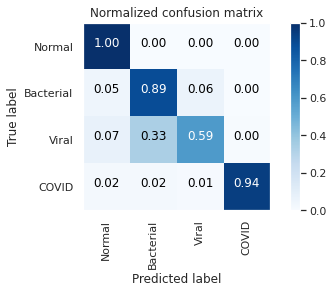

282/282 [==============================] - 52s 185ms/step - loss: 0.2628 - accuracy: 0.8624 - val_loss: 0.4907 - val_accuracy: 0.8510
Epoch 48/70
282/282 [==============================] - ETA: 0s - loss: 0.2682 - accuracy: 0.8599
Epoch 00048: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.187418


---------------------
| Balanced Accuracy  |
---------------------

    0.8560115362859214


---------------------
|      Accuracy      |
---------------------

    0.8423236514522822


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       237
           1       0.86      0.84      0.85       417
           2       0.74      0.64      0.69       224
           3       0.98      0.94      0.96        86

    accuracy                           0.84       

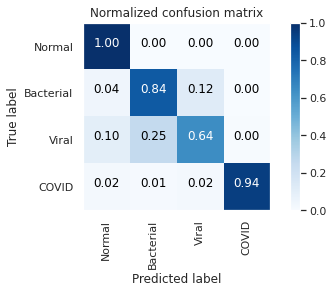

282/282 [==============================] - 52s 184ms/step - loss: 0.2682 - accuracy: 0.8599 - val_loss: 0.4646 - val_accuracy: 0.8417
Epoch 49/70
282/282 [==============================] - ETA: 0s - loss: 0.2460 - accuracy: 0.8703
Epoch 00049: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.188326


---------------------
| Balanced Accuracy  |
---------------------

    0.8537453467458591


---------------------
|      Accuracy      |
---------------------

    0.8402489626556017


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       237
           1       0.85      0.86      0.86       417
           2       0.76      0.59      0.67       224
           3       0.97      0.97      0.97        86

    accuracy                           0.84       

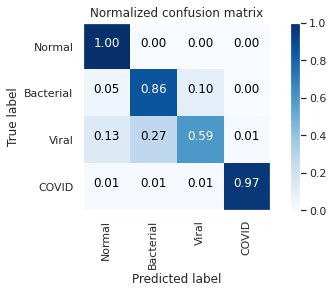

282/282 [==============================] - 52s 184ms/step - loss: 0.2460 - accuracy: 0.8703 - val_loss: 0.4477 - val_accuracy: 0.8396
Epoch 50/70
282/282 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.8719
Epoch 00050: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.206002


---------------------
| Balanced Accuracy  |
---------------------

    0.8384244780990885


---------------------
|      Accuracy      |
---------------------

    0.7717842323651453


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       237
           1       0.88      0.59      0.71       417
           2       0.52      0.80      0.63       224
           3       0.99      0.98      0.98        86

    accuracy                           0.77       

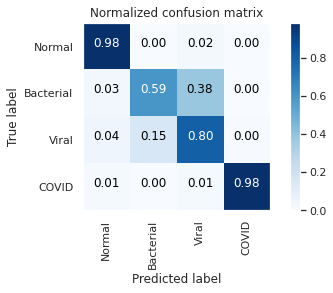

282/282 [==============================] - 52s 184ms/step - loss: 0.2425 - accuracy: 0.8719 - val_loss: 0.5399 - val_accuracy: 0.7708
Epoch 51/70
282/282 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.8777
Epoch 00051: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.199137


---------------------
| Balanced Accuracy  |
---------------------

    0.8622534144978898


---------------------
|      Accuracy      |
---------------------

    0.8516597510373444


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       237
           1       0.85      0.88      0.87       417
           2       0.82      0.60      0.69       224
           3       0.97      0.98      0.97        86

    accuracy                           0.85       

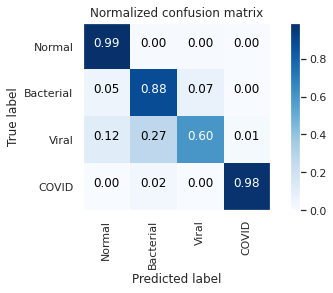

282/282 [==============================] - 52s 184ms/step - loss: 0.2330 - accuracy: 0.8777 - val_loss: 0.5689 - val_accuracy: 0.8510
Epoch 52/70
282/282 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.8792
Epoch 00052: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.206777


---------------------
| Balanced Accuracy  |
---------------------

    0.8344185048739678


---------------------
|      Accuracy      |
---------------------

    0.8174273858921162


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       237
           1       0.83      0.83      0.83       417
           2       0.75      0.54      0.63       224
           3       0.99      0.97      0.98        86

    accuracy                           0.82       

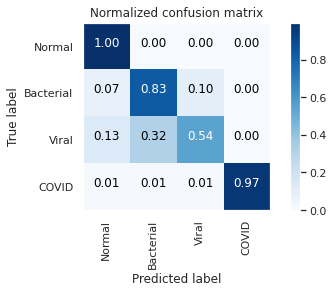

282/282 [==============================] - 52s 185ms/step - loss: 0.2315 - accuracy: 0.8792 - val_loss: 0.6188 - val_accuracy: 0.8167
Epoch 53/70
282/282 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.8732
Epoch 00053: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.190613


---------------------
| Balanced Accuracy  |
---------------------

    0.838990933499048


---------------------
|      Accuracy      |
---------------------

    0.8112033195020747


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       237
           1       0.85      0.80      0.82       417
           2       0.75      0.57      0.65       224
           3       0.96      0.99      0.97        86

    accuracy                           0.81       9

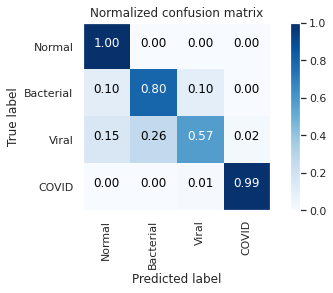

282/282 [==============================] - 52s 184ms/step - loss: 0.2421 - accuracy: 0.8732 - val_loss: 0.6072 - val_accuracy: 0.8104
Epoch 54/70
282/282 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.8681
Epoch 00054: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.200680


---------------------
| Balanced Accuracy  |
---------------------

    0.837547217209621


---------------------
|      Accuracy      |
---------------------

    0.8215767634854771


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       237
           1       0.83      0.83      0.83       417
           2       0.75      0.57      0.65       224
           3       0.95      0.95      0.95        86

    accuracy                           0.82       9

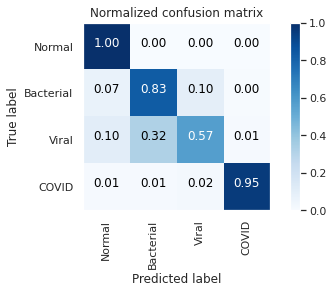

282/282 [==============================] - 52s 184ms/step - loss: 0.2453 - accuracy: 0.8681 - val_loss: 0.5700 - val_accuracy: 0.8208
Epoch 55/70
282/282 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.8754
Epoch 00055: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.205419


---------------------
| Balanced Accuracy  |
---------------------

    0.8178463873419536


---------------------
|      Accuracy      |
---------------------

    0.8112033195020747


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       237
           1       0.79      0.88      0.83       417
           2       0.79      0.43      0.56       224
           3       0.97      0.97      0.97        86

    accuracy                           0.81       

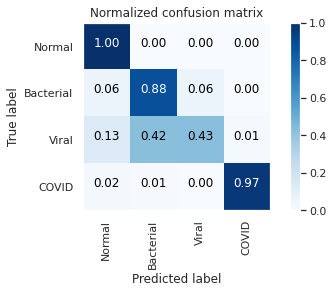

282/282 [==============================] - 52s 184ms/step - loss: 0.2558 - accuracy: 0.8754 - val_loss: 0.5850 - val_accuracy: 0.8104
Epoch 56/70
282/282 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.8821
Epoch 00056: val_accuracy did not improve from 0.86979
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.213570


---------------------
| Balanced Accuracy  |
---------------------

    0.852504603460089


---------------------
|      Accuracy      |
---------------------

    0.8350622406639004


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       237
           1       0.83      0.86      0.85       417
           2       0.79      0.55      0.65       224
           3       0.97      1.00      0.98        86

    accuracy                           0.84       9

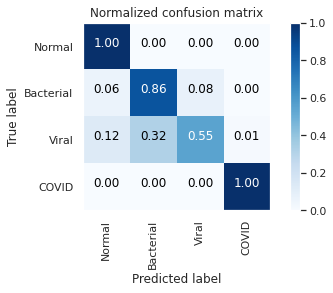

282/282 [==============================] - 52s 185ms/step - loss: 0.2219 - accuracy: 0.8821 - val_loss: 0.5579 - val_accuracy: 0.8344
Epoch 57/70
 70/282 [======>.......................] - ETA: 35s - loss: 0.1998 - accuracy: 0.9036

In [ ]:
class_weights = {0: 1.01805054, 1: 0.57965057,  2: 1.06919431, 3: 2.79900744}
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_data) // train_generator.batch_size,
                              validation_data=val_generator,
                              validation_steps= len(test_data)// val_generator.batch_size, #change the val/test properly eventhough it doesnt affect the process
                              class_weight = class_weights,
                              epochs = 70,
                              callbacks = get_callbacks(),
                              verbose = 1
                              )

Saving Model


In [ ]:
model.save('ClsModel2.h5')

Plotting Model

In [ ]:
plot_model(model, show_shapes=True)

## **8. Visualizing the model performance**

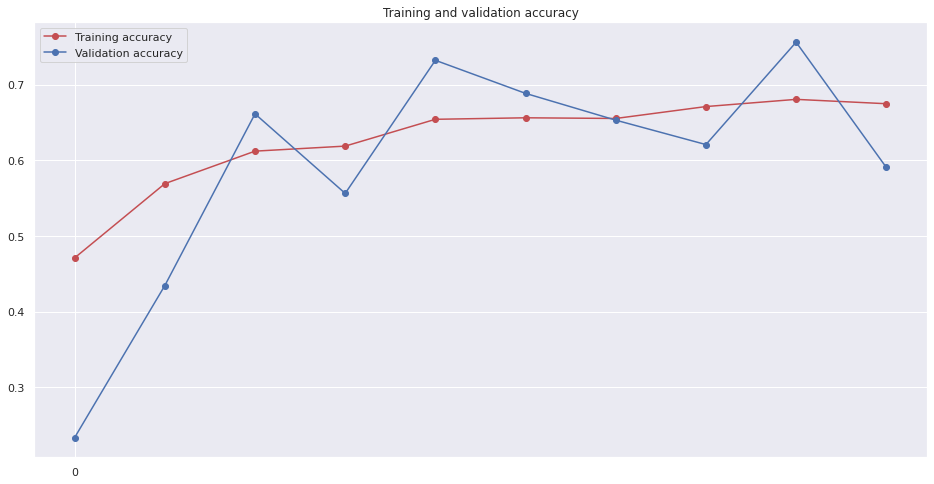

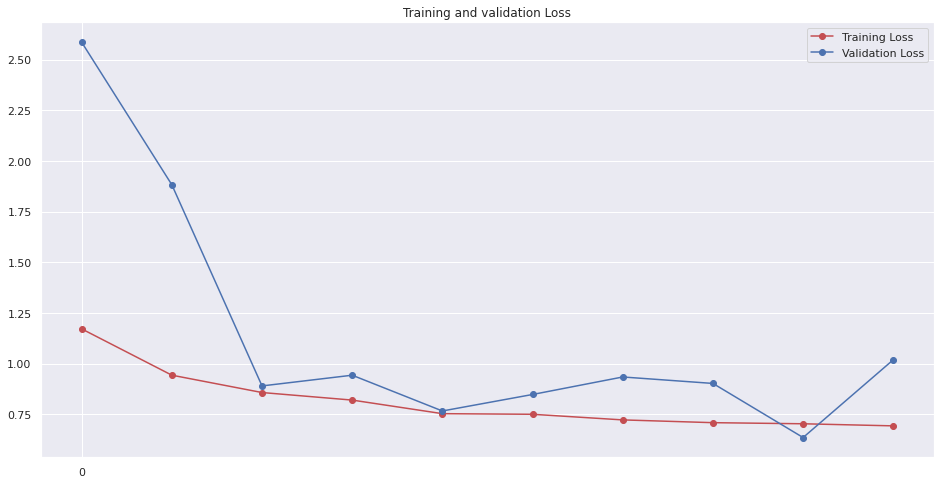

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()


## **9. ROC Curve**

In [ ]:
model=load_model('/content/drive/MyDrive/ClsModel.h5')

In [ ]:
preds_all=model.predict(val2_generator)
preds_all

array([[8.40539873e-01, 2.55007669e-02, 1.33840606e-01, 1.18737284e-04],
       [9.95336354e-01, 6.03383116e-04, 4.04871535e-03, 1.16549008e-05],
       [9.99899387e-01, 8.59454758e-06, 8.76754348e-05, 4.31903891e-06],
       ...,
       [3.66061613e-05, 1.05656385e-04, 4.37503368e-05, 9.99813974e-01],
       [4.82690302e-05, 2.29639718e-05, 1.22823067e-05, 9.99916434e-01],
       [1.22200319e-04, 6.73345174e-04, 2.88354815e-04, 9.98916030e-01]],
      dtype=float32)

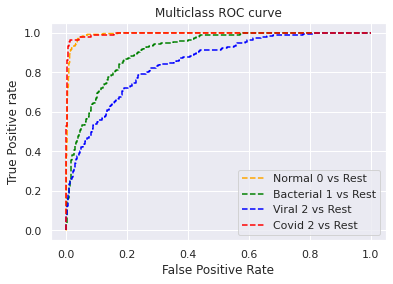

In [ ]:
val_labels=np.load('/content/drive/MyDrive/val_labels.npy')
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(val_labels, preds_all[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Normal 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Bacterial 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Viral 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Covid 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## **10. Binary classification**

The bacterial, viral (non-covid) and normal x-rays were assigned as non-COVID class. The model was run against COVID vs non-COVID as shown above. The best model was saved and extracted to view the accuracy for binary classification.

In [ ]:
model=load_model('/content/drive/MyDrive/BinaryCls.h5')

Epoch 1/70
282/282 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7150
Epoch 00001: val_accuracy improved from -inf to 0.91458, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:04.512725


---------------------
| Balanced Accuracy  |
---------------------

    0.5


---------------------
|      Accuracy      |
---------------------

    0.9107883817427386


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       878
           1       0.00      0.00      0.00        86

    accuracy                           0.91       964
   macro avg       0.46      0.50      0.48       964
weighted avg       0.83      0.91      0.87       964

--------------------
| Confusion Matrix |
--------------------

 [[878   0]
 [ 86   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


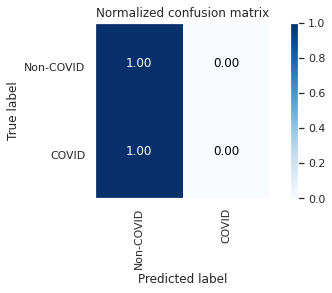

282/282 [==============================] - 57s 203ms/step - loss: 0.6319 - accuracy: 0.7150 - val_loss: 0.4487 - val_accuracy: 0.9146
Epoch 2/70
282/282 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.7868
Epoch 00002: val_accuracy did not improve from 0.91458
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.162896


---------------------
| Balanced Accuracy  |
---------------------

    0.5


---------------------
|      Accuracy      |
---------------------

    0.9107883817427386


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       878
           1       0.00      0.00      0.00        86

    accuracy                           0.91       964
   macro avg       0.46      0.50      0.48       964
weighted avg       0.83      0.91      0.87       964

-----------

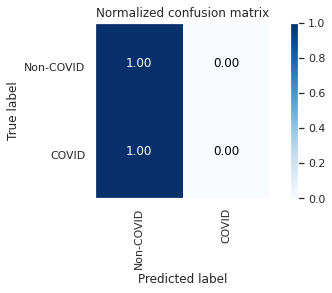

282/282 [==============================] - 51s 180ms/step - loss: 0.4166 - accuracy: 0.7868 - val_loss: 0.2945 - val_accuracy: 0.9146
Epoch 3/70
282/282 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8584
Epoch 00003: val_accuracy improved from 0.91458 to 0.96042, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.168543


---------------------
| Balanced Accuracy  |
---------------------

    0.9573819992583568


---------------------
|      Accuracy      |
---------------------

    0.9605809128630706


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.71      0.95      0.81        86

    accuracy                           0.96       964
   macro avg       0.85      0.96      0.89      

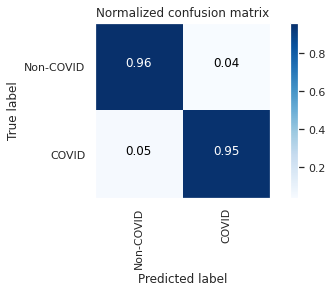

282/282 [==============================] - 52s 184ms/step - loss: 0.3198 - accuracy: 0.8584 - val_loss: 0.1479 - val_accuracy: 0.9604
Epoch 4/70
282/282 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8799
Epoch 00004: val_accuracy did not improve from 0.96042
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.183109


---------------------
| Balanced Accuracy  |
---------------------

    0.8942893468241776


---------------------
|      Accuracy      |
---------------------

    0.8360995850622407


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       878
           1       0.35      0.97      0.51        86

    accuracy                           0.84       964
   macro avg       0.67      0.89      0.71       964
weighted avg       0.94      0.84      0.87       9

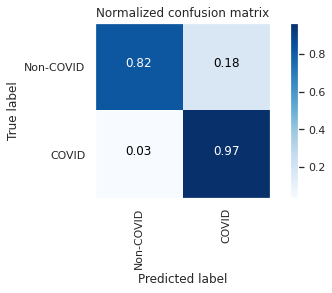

282/282 [==============================] - 51s 180ms/step - loss: 0.3024 - accuracy: 0.8799 - val_loss: 0.3126 - val_accuracy: 0.8354
Epoch 5/70
282/282 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8854
Epoch 00005: val_accuracy did not improve from 0.96042
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.157663


---------------------
| Balanced Accuracy  |
---------------------

    0.9610372410870371


---------------------
|      Accuracy      |
---------------------

    0.9481327800829875


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       878
           1       0.64      0.98      0.77        86

    accuracy                           0.95       964
   macro avg       0.82      0.96      0.87       964
weighted avg       0.97      0.95      0.95       9

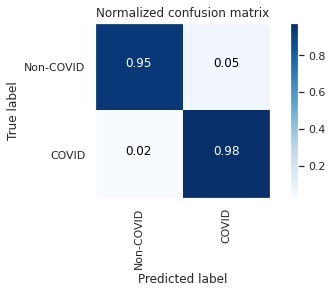

282/282 [==============================] - 51s 179ms/step - loss: 0.2776 - accuracy: 0.8854 - val_loss: 0.1511 - val_accuracy: 0.9479
Epoch 6/70
282/282 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9065
Epoch 00006: val_accuracy did not improve from 0.96042
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.154854


---------------------
| Balanced Accuracy  |
---------------------

    0.9530645759389733


---------------------
|      Accuracy      |
---------------------

    0.9336099585062241


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       878
           1       0.58      0.98      0.72        86

    accuracy                           0.93       964
   macro avg       0.79      0.95      0.84       964
weighted avg       0.96      0.93      0.94       9

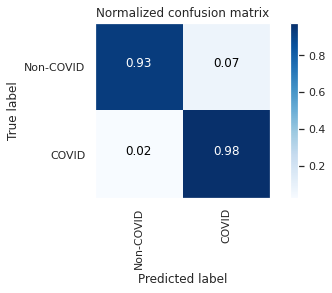

282/282 [==============================] - 50s 179ms/step - loss: 0.2238 - accuracy: 0.9065 - val_loss: 0.1723 - val_accuracy: 0.9333
Epoch 7/70
282/282 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8969
Epoch 00007: val_accuracy improved from 0.96042 to 0.97812, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.174542


---------------------
| Balanced Accuracy  |
---------------------

    0.9723075700588018


---------------------
|      Accuracy      |
---------------------

    0.9782157676348547


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.82      0.97      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.97      0.94      

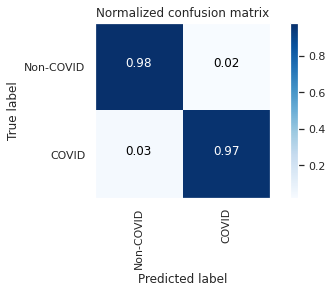

282/282 [==============================] - 52s 184ms/step - loss: 0.2560 - accuracy: 0.8969 - val_loss: 0.1108 - val_accuracy: 0.9781
Epoch 8/70
282/282 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9246
Epoch 00008: val_accuracy did not improve from 0.97812
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.159663


---------------------
| Balanced Accuracy  |
---------------------

    0.9607988557503842


---------------------
|      Accuracy      |
---------------------

    0.966804979253112


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       878
           1       0.75      0.95      0.84        86

    accuracy                           0.97       964
   macro avg       0.87      0.96      0.91       964
weighted avg       0.97      0.97      0.97       96

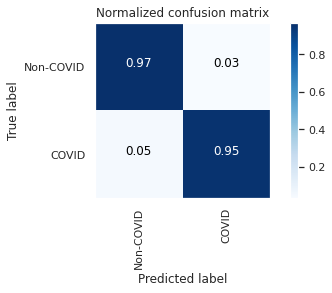

282/282 [==============================] - 51s 179ms/step - loss: 0.2226 - accuracy: 0.9246 - val_loss: 0.1363 - val_accuracy: 0.9667
Epoch 9/70
282/282 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9240
Epoch 00009: val_accuracy did not improve from 0.97812
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.164110


---------------------
| Balanced Accuracy  |
---------------------

    0.9586401440906924


---------------------
|      Accuracy      |
---------------------

    0.9533195020746889


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       878
           1       0.66      0.97      0.79        86

    accuracy                           0.95       964
   macro avg       0.83      0.96      0.88       964
weighted avg       0.97      0.95      0.96       9

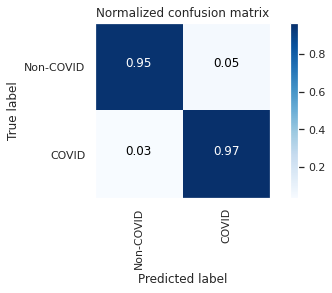

282/282 [==============================] - 51s 179ms/step - loss: 0.2104 - accuracy: 0.9240 - val_loss: 0.1492 - val_accuracy: 0.9531
Epoch 10/70
282/282 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9151
Epoch 00010: val_accuracy did not improve from 0.97812
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.154873


---------------------
| Balanced Accuracy  |
---------------------

    0.7369020501138952


---------------------
|      Accuracy      |
---------------------

    0.520746887966805


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.47      0.64       878
           1       0.16      1.00      0.27        86

    accuracy                           0.52       964
   macro avg       0.58      0.74      0.46       964
weighted avg       0.92      0.52      0.61       9

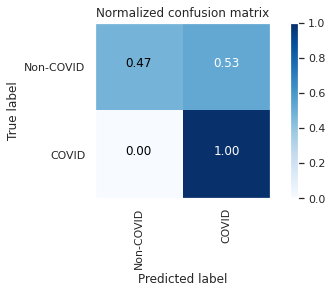

282/282 [==============================] - 50s 179ms/step - loss: 0.1955 - accuracy: 0.9151 - val_loss: 0.9399 - val_accuracy: 0.5188
Epoch 11/70
282/282 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.8927
Epoch 00011: val_accuracy did not improve from 0.97812
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.164732


---------------------
| Balanced Accuracy  |
---------------------

    0.9742543836414684


---------------------
|      Accuracy      |
---------------------

    0.9626556016597511


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.71      0.99      0.83        86

    accuracy                           0.96       964
   macro avg       0.85      0.97      0.90       964
weighted avg       0.97      0.96      0.97       

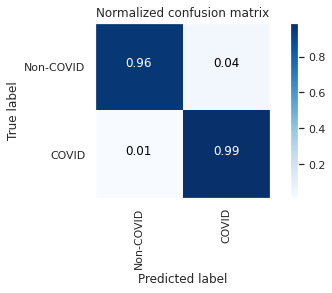

282/282 [==============================] - 51s 180ms/step - loss: 0.2733 - accuracy: 0.8927 - val_loss: 0.0990 - val_accuracy: 0.9625
Epoch 12/70
282/282 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.9129
Epoch 00012: val_accuracy improved from 0.97812 to 0.97917, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.157023


---------------------
| Balanced Accuracy  |
---------------------

    0.9781215235471739


---------------------
|      Accuracy      |
---------------------

    0.979253112033195


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.82      0.98      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.98      0.94      

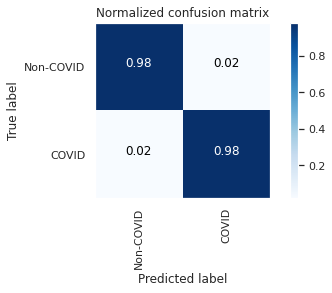

282/282 [==============================] - 52s 183ms/step - loss: 0.2370 - accuracy: 0.9129 - val_loss: 0.0575 - val_accuracy: 0.9792
Epoch 13/70
282/282 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9191
Epoch 00013: val_accuracy did not improve from 0.97917
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.153676


---------------------
| Balanced Accuracy  |
---------------------

    0.9728770461408063


---------------------
|      Accuracy      |
---------------------

    0.979253112033195


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.83      0.97      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.97      0.94       964
weighted avg       0.98      0.98      0.98       9

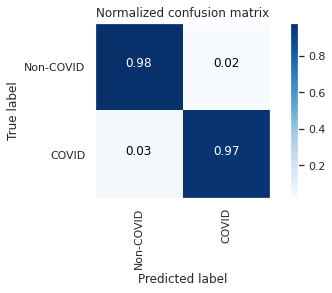

282/282 [==============================] - 50s 179ms/step - loss: 0.2022 - accuracy: 0.9191 - val_loss: 0.0536 - val_accuracy: 0.9792
Epoch 14/70
282/282 [==============================] - ETA: 0s - loss: 0.1741 - accuracy: 0.9249
Epoch 00014: val_accuracy did not improve from 0.97917
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.156468


---------------------
| Balanced Accuracy  |
---------------------

    0.9758436192191555


---------------------
|      Accuracy      |
---------------------

    0.975103734439834


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       878
           1       0.79      0.98      0.88        86

    accuracy                           0.98       964
   macro avg       0.90      0.98      0.93       964
weighted avg       0.98      0.98      0.98       9

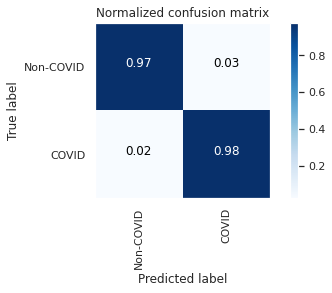

282/282 [==============================] - 51s 179ms/step - loss: 0.1741 - accuracy: 0.9249 - val_loss: 0.0645 - val_accuracy: 0.9750
Epoch 15/70
282/282 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9377
Epoch 00015: val_accuracy did not improve from 0.97917
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.156947


---------------------
| Balanced Accuracy  |
---------------------

    0.9729962388091328


---------------------
|      Accuracy      |
---------------------

    0.9699170124481328


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       878
           1       0.76      0.98      0.85        86

    accuracy                           0.97       964
   macro avg       0.88      0.97      0.92       964
weighted avg       0.98      0.97      0.97       

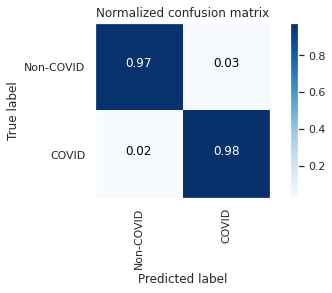

282/282 [==============================] - 51s 180ms/step - loss: 0.1851 - accuracy: 0.9377 - val_loss: 0.0817 - val_accuracy: 0.9698
Epoch 16/70
282/282 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9473
Epoch 00016: val_accuracy improved from 0.97917 to 0.98750, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.168042


---------------------
| Balanced Accuracy  |
---------------------

    0.9826773322032103


---------------------
|      Accuracy      |
---------------------

    0.9875518672199171


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.89      0.98      0.93        86

    accuracy                           0.99       964
   macro avg       0.95      0.98      0.96     

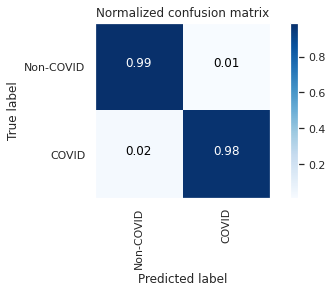

282/282 [==============================] - 52s 184ms/step - loss: 0.1629 - accuracy: 0.9473 - val_loss: 0.0562 - val_accuracy: 0.9875
Epoch 17/70
282/282 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9490
Epoch 00017: val_accuracy improved from 0.98750 to 0.99167, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.161855


---------------------
| Balanced Accuracy  |
---------------------

    0.9797107591248609


---------------------
|      Accuracy      |
---------------------

    0.991701244813278


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       878
           1       0.94      0.97      0.95        86

    accuracy                           0.99       964
   macro avg       0.97      0.98      0.97      

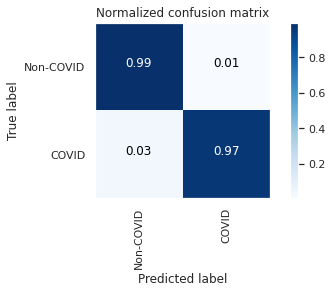

282/282 [==============================] - 52s 183ms/step - loss: 0.1464 - accuracy: 0.9490 - val_loss: 0.0540 - val_accuracy: 0.9917
Epoch 18/70
282/282 [==============================] - ETA: 0s - loss: 0.1947 - accuracy: 0.9246
Epoch 00018: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.168408


---------------------
| Balanced Accuracy  |
---------------------

    0.9758436192191555


---------------------
|      Accuracy      |
---------------------

    0.975103734439834


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       878
           1       0.79      0.98      0.88        86

    accuracy                           0.98       964
   macro avg       0.90      0.98      0.93       964
weighted avg       0.98      0.98      0.98       9

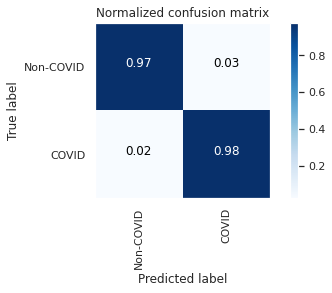

282/282 [==============================] - 51s 180ms/step - loss: 0.1947 - accuracy: 0.9246 - val_loss: 0.0918 - val_accuracy: 0.9750
Epoch 19/70
282/282 [==============================] - ETA: 0s - loss: 0.1841 - accuracy: 0.9282
Epoch 00019: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.170214


---------------------
| Balanced Accuracy  |
---------------------

    0.9791412830428564


---------------------
|      Accuracy      |
---------------------

    0.9906639004149378


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.93      0.97      0.95        86

    accuracy                           0.99       964
   macro avg       0.96      0.98      0.97       964
weighted avg       0.99      0.99      0.99       

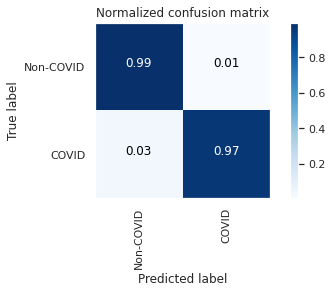

282/282 [==============================] - 50s 179ms/step - loss: 0.1841 - accuracy: 0.9282 - val_loss: 0.0693 - val_accuracy: 0.9906
Epoch 20/70
282/282 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9366
Epoch 00020: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.157807


---------------------
| Balanced Accuracy  |
---------------------

    0.9786909996291784


---------------------
|      Accuracy      |
---------------------

    0.9802904564315352


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.83      0.98      0.90        86

    accuracy                           0.98       964
   macro avg       0.91      0.98      0.94       964
weighted avg       0.98      0.98      0.98       

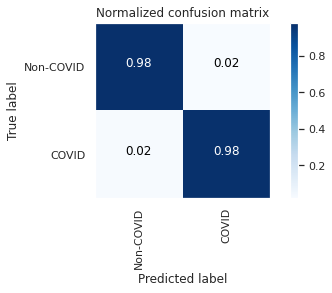

282/282 [==============================] - 50s 178ms/step - loss: 0.1814 - accuracy: 0.9366 - val_loss: 0.0735 - val_accuracy: 0.9802
Epoch 21/70
282/282 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9464
Epoch 00021: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.157415


---------------------
| Balanced Accuracy  |
---------------------

    0.9716189013084706


---------------------
|      Accuracy      |
---------------------

    0.9865145228215768


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.90      0.95      0.93        86

    accuracy                           0.99       964
   macro avg       0.95      0.97      0.96       964
weighted avg       0.99      0.99      0.99       

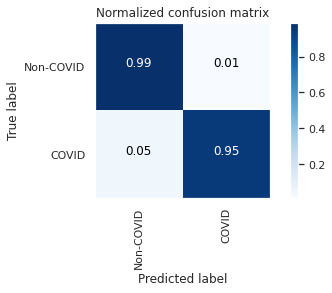

282/282 [==============================] - 51s 179ms/step - loss: 0.1673 - accuracy: 0.9464 - val_loss: 0.0742 - val_accuracy: 0.9865
Epoch 22/70
282/282 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9242
Epoch 00022: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.156171


---------------------
| Balanced Accuracy  |
---------------------

    0.9587593367590188


---------------------
|      Accuracy      |
---------------------

    0.9439834024896265


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       878
           1       0.62      0.98      0.76        86

    accuracy                           0.94       964
   macro avg       0.81      0.96      0.86       964
weighted avg       0.96      0.94      0.95       

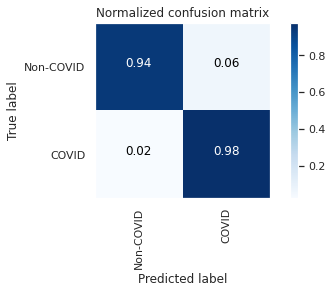

282/282 [==============================] - 50s 179ms/step - loss: 0.1786 - accuracy: 0.9242 - val_loss: 0.1527 - val_accuracy: 0.9438
Epoch 23/70
282/282 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9355
Epoch 00023: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.151543


---------------------
| Balanced Accuracy  |
---------------------

    0.9694601896487789


---------------------
|      Accuracy      |
---------------------

    0.9730290456431535


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       878
           1       0.78      0.97      0.86        86

    accuracy                           0.97       964
   macro avg       0.89      0.97      0.92       964
weighted avg       0.98      0.97      0.97       

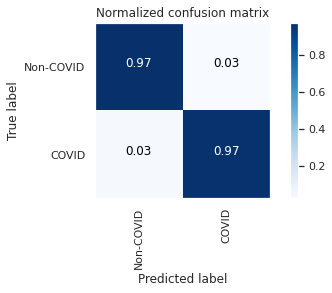

282/282 [==============================] - 51s 180ms/step - loss: 0.1830 - accuracy: 0.9355 - val_loss: 0.0902 - val_accuracy: 0.9729
Epoch 24/70
282/282 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9382
Epoch 00024: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.155682


---------------------
| Balanced Accuracy  |
---------------------

    0.9809689039571965


---------------------
|      Accuracy      |
---------------------

    0.9844398340248963


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.87      0.98      0.92        86

    accuracy                           0.98       964
   macro avg       0.93      0.98      0.95       964
weighted avg       0.99      0.98      0.98       

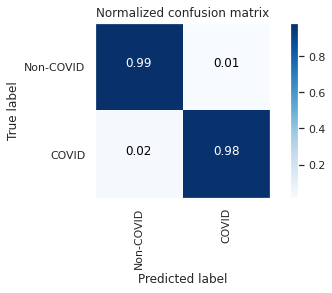

282/282 [==============================] - 51s 179ms/step - loss: 0.1786 - accuracy: 0.9382 - val_loss: 0.0579 - val_accuracy: 0.9844
Epoch 25/70
282/282 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9428
Epoch 00025: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.146298


---------------------
| Balanced Accuracy  |
---------------------

    0.9712878105631191


---------------------
|      Accuracy      |
---------------------

    0.966804979253112


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       878
           1       0.74      0.98      0.84        86

    accuracy                           0.97       964
   macro avg       0.87      0.97      0.91       964
weighted avg       0.97      0.97      0.97       9

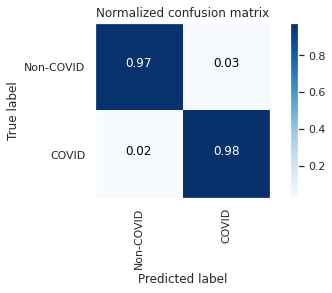

282/282 [==============================] - 50s 179ms/step - loss: 0.1771 - accuracy: 0.9428 - val_loss: 0.1579 - val_accuracy: 0.9667
Epoch 26/70
282/282 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9541
Epoch 00026: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.175018


---------------------
| Balanced Accuracy  |
---------------------

    0.9809689039571965


---------------------
|      Accuracy      |
---------------------

    0.9844398340248963


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.87      0.98      0.92        86

    accuracy                           0.98       964
   macro avg       0.93      0.98      0.95       964
weighted avg       0.99      0.98      0.98       

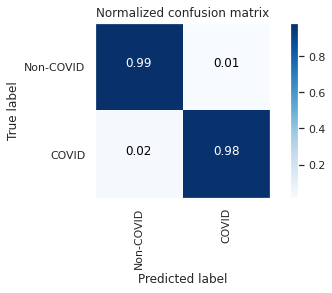

282/282 [==============================] - 51s 179ms/step - loss: 0.1466 - accuracy: 0.9541 - val_loss: 0.0491 - val_accuracy: 0.9844
Epoch 27/70
282/282 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9632
Epoch 00027: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.179867


---------------------
| Balanced Accuracy  |
---------------------

    0.9843857604492239


---------------------
|      Accuracy      |
---------------------

    0.9906639004149378


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.92      0.98      0.95        86

    accuracy                           0.99       964
   macro avg       0.96      0.98      0.97       964
weighted avg       0.99      0.99      0.99       

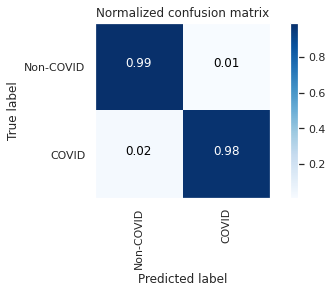

282/282 [==============================] - 51s 180ms/step - loss: 0.1309 - accuracy: 0.9632 - val_loss: 0.1031 - val_accuracy: 0.9906
Epoch 28/70
282/282 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9506
Epoch 00028: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.176224


---------------------
| Balanced Accuracy  |
---------------------

    0.969009906235101


---------------------
|      Accuracy      |
---------------------

    0.9626556016597511


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.71      0.98      0.82        86

    accuracy                           0.96       964
   macro avg       0.85      0.97      0.90       964
weighted avg       0.97      0.96      0.97       9

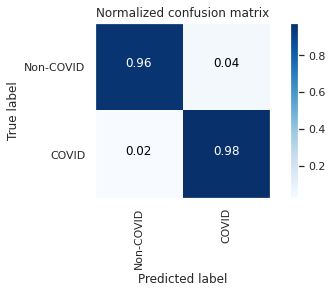

282/282 [==============================] - 51s 180ms/step - loss: 0.1374 - accuracy: 0.9506 - val_loss: 0.1057 - val_accuracy: 0.9625
Epoch 29/70
282/282 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9574
Epoch 00029: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.176649


---------------------
| Balanced Accuracy  |
---------------------

    0.9673014779890872


---------------------
|      Accuracy      |
---------------------

    0.9595435684647303


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.69      0.98      0.81        86

    accuracy                           0.96       964
   macro avg       0.85      0.97      0.89       964
weighted avg       0.97      0.96      0.96       

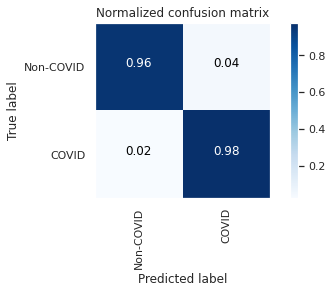

282/282 [==============================] - 51s 180ms/step - loss: 0.1325 - accuracy: 0.9574 - val_loss: 0.1100 - val_accuracy: 0.9594
Epoch 30/70
282/282 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9590
Epoch 00030: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.173826


---------------------
| Balanced Accuracy  |
---------------------

    0.9618186152460666


---------------------
|      Accuracy      |
---------------------

    0.9782157676348547


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       878
           1       0.84      0.94      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.96      0.94       964
weighted avg       0.98      0.98      0.98       

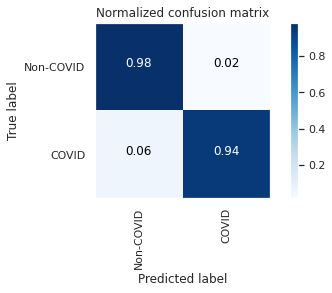

282/282 [==============================] - 51s 180ms/step - loss: 0.1392 - accuracy: 0.9590 - val_loss: 0.0517 - val_accuracy: 0.9781
Epoch 31/70
282/282 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.9481
Epoch 00031: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.170895


---------------------
| Balanced Accuracy  |
---------------------

    0.9631959527467289


---------------------
|      Accuracy      |
---------------------

    0.9616182572614108


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.71      0.97      0.82        86

    accuracy                           0.96       964
   macro avg       0.85      0.96      0.90       964
weighted avg       0.97      0.96      0.96       

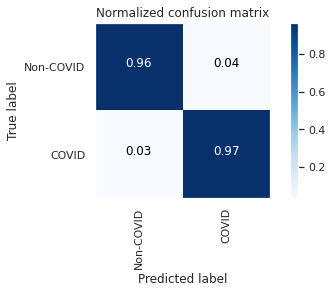

282/282 [==============================] - 51s 180ms/step - loss: 0.1241 - accuracy: 0.9481 - val_loss: 0.0772 - val_accuracy: 0.9615
Epoch 32/70
282/282 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8996
Epoch 00032: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.174267


---------------------
| Balanced Accuracy  |
---------------------

    0.9809689039571965


---------------------
|      Accuracy      |
---------------------

    0.9844398340248963


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.87      0.98      0.92        86

    accuracy                           0.98       964
   macro avg       0.93      0.98      0.95       964
weighted avg       0.99      0.98      0.98       

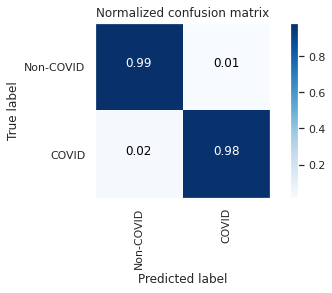

282/282 [==============================] - 51s 180ms/step - loss: 0.2598 - accuracy: 0.8996 - val_loss: 0.0568 - val_accuracy: 0.9844
Epoch 33/70
282/282 [==============================] - ETA: 0s - loss: 0.1624 - accuracy: 0.9504
Epoch 00033: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.182362


---------------------
| Balanced Accuracy  |
---------------------

    0.9727578534724797


---------------------
|      Accuracy      |
---------------------

    0.9885892116182573


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.92      0.95      0.94        86

    accuracy                           0.99       964
   macro avg       0.96      0.97      0.97       964
weighted avg       0.99      0.99      0.99       

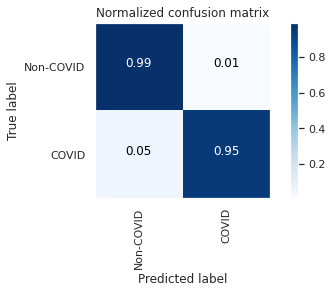

282/282 [==============================] - 51s 180ms/step - loss: 0.1624 - accuracy: 0.9504 - val_loss: 0.0554 - val_accuracy: 0.9885
Epoch 34/70
282/282 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9479
Epoch 00034: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.175447


---------------------
| Balanced Accuracy  |
---------------------

    0.9734465222228108


---------------------
|      Accuracy      |
---------------------

    0.9802904564315352


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.84      0.97      0.90        86

    accuracy                           0.98       964
   macro avg       0.92      0.97      0.94       964
weighted avg       0.98      0.98      0.98       

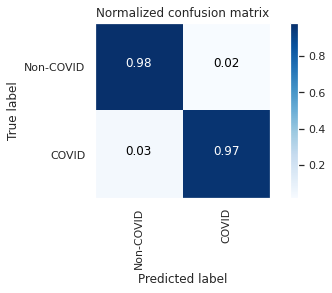

282/282 [==============================] - 51s 180ms/step - loss: 0.1455 - accuracy: 0.9479 - val_loss: 0.0692 - val_accuracy: 0.9802
Epoch 35/70
282/282 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9313
Epoch 00035: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.177639


---------------------
| Balanced Accuracy  |
---------------------

    0.9774328547968427


---------------------
|      Accuracy      |
---------------------

    0.9875518672199171


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.90      0.97      0.93        86

    accuracy                           0.99       964
   macro avg       0.95      0.98      0.96       964
weighted avg       0.99      0.99      0.99       

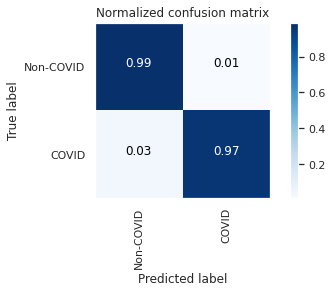

282/282 [==============================] - 51s 180ms/step - loss: 0.1817 - accuracy: 0.9313 - val_loss: 0.0532 - val_accuracy: 0.9875
Epoch 36/70
282/282 [==============================] - ETA: 0s - loss: 0.1667 - accuracy: 0.9266
Epoch 00036: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.185291


---------------------
| Balanced Accuracy  |
---------------------

    0.8103379774328547


---------------------
|      Accuracy      |
---------------------

    0.7022821576763485


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       878
           1       0.22      0.94      0.36        86

    accuracy                           0.70       964
   macro avg       0.61      0.81      0.58       964
weighted avg       0.92      0.70      0.77       

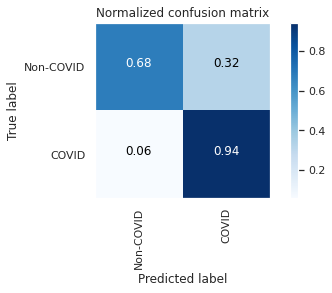

282/282 [==============================] - 51s 180ms/step - loss: 0.1667 - accuracy: 0.9266 - val_loss: 0.7158 - val_accuracy: 0.7010
Epoch 37/70
282/282 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.7919
Epoch 00037: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.159175


---------------------
| Balanced Accuracy  |
---------------------

    0.9375695290565238


---------------------
|      Accuracy      |
---------------------

    0.9149377593360996


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       878
           1       0.51      0.97      0.67        86

    accuracy                           0.91       964
   macro avg       0.75      0.94      0.81       964
weighted avg       0.95      0.91      0.93       

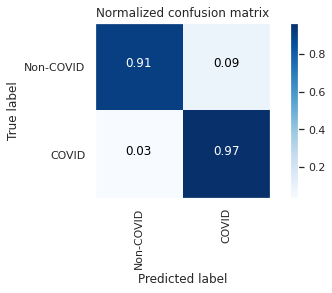

282/282 [==============================] - 51s 179ms/step - loss: 0.5043 - accuracy: 0.7919 - val_loss: 0.3089 - val_accuracy: 0.9146
Epoch 38/70
282/282 [==============================] - ETA: 0s - loss: 0.2809 - accuracy: 0.9065
Epoch 00038: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.159799


---------------------
| Balanced Accuracy  |
---------------------

    0.9724267627271282


---------------------
|      Accuracy      |
---------------------

    0.9688796680497925


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       878
           1       0.75      0.98      0.85        86

    accuracy                           0.97       964
   macro avg       0.87      0.97      0.92       964
weighted avg       0.98      0.97      0.97       

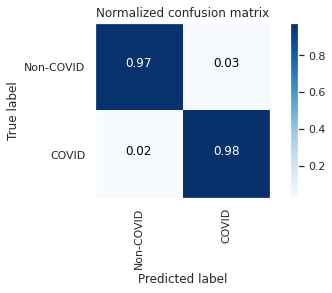

282/282 [==============================] - 50s 179ms/step - loss: 0.2809 - accuracy: 0.9065 - val_loss: 0.1035 - val_accuracy: 0.9688
Epoch 39/70
282/282 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.9089
Epoch 00039: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.207472


---------------------
| Balanced Accuracy  |
---------------------

    0.9815383800392011


---------------------
|      Accuracy      |
---------------------

    0.9854771784232366


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.88      0.98      0.92        86

    accuracy                           0.99       964
   macro avg       0.94      0.98      0.96       964
weighted avg       0.99      0.99      0.99       

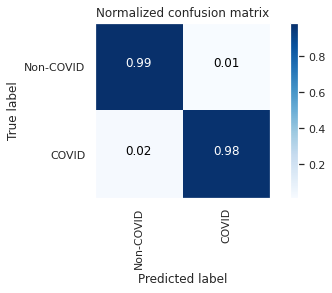

282/282 [==============================] - 51s 179ms/step - loss: 0.2346 - accuracy: 0.9089 - val_loss: 0.0470 - val_accuracy: 0.9854
Epoch 40/70
282/282 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9391
Epoch 00040: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.155805


---------------------
| Balanced Accuracy  |
---------------------

    0.9702680510674366


---------------------
|      Accuracy      |
---------------------

    0.9553941908713693


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       878
           1       0.67      0.99      0.80        86

    accuracy                           0.96       964
   macro avg       0.83      0.97      0.89       964
weighted avg       0.97      0.96      0.96       

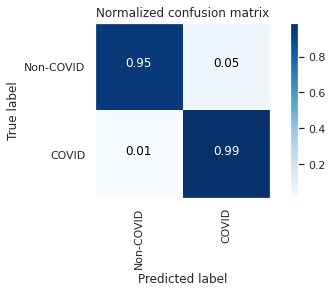

282/282 [==============================] - 50s 179ms/step - loss: 0.1643 - accuracy: 0.9391 - val_loss: 0.1305 - val_accuracy: 0.9552
Epoch 41/70
282/282 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9415
Epoch 00041: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.166900


---------------------
| Balanced Accuracy  |
---------------------

    0.8194760820045558


---------------------
|      Accuracy      |
---------------------

    0.671161825726141


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.64      0.78       878
           1       0.21      1.00      0.35        86

    accuracy                           0.67       964
   macro avg       0.61      0.82      0.57       964
weighted avg       0.93      0.67      0.74       9

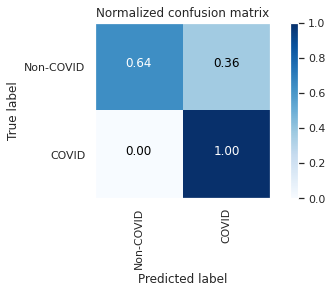

282/282 [==============================] - 51s 180ms/step - loss: 0.1646 - accuracy: 0.9415 - val_loss: 0.7599 - val_accuracy: 0.6698
Epoch 42/70
282/282 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9444
Epoch 00042: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.189940


---------------------
| Balanced Accuracy  |
---------------------

    0.9867828574455686


---------------------
|      Accuracy      |
---------------------

    0.9854771784232366


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.87      0.99      0.92        86

    accuracy                           0.99       964
   macro avg       0.93      0.99      0.96       964
weighted avg       0.99      0.99      0.99       

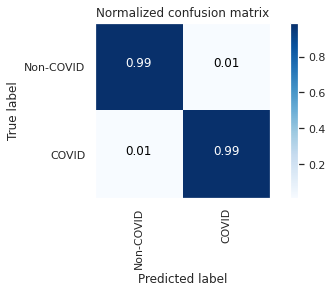

282/282 [==============================] - 51s 180ms/step - loss: 0.1587 - accuracy: 0.9444 - val_loss: 0.0409 - val_accuracy: 0.9854
Epoch 43/70
282/282 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9501
Epoch 00043: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.167506


---------------------
| Balanced Accuracy  |
---------------------

    0.9781215235471739


---------------------
|      Accuracy      |
---------------------

    0.979253112033195


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.82      0.98      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.98      0.94       964
weighted avg       0.98      0.98      0.98       9

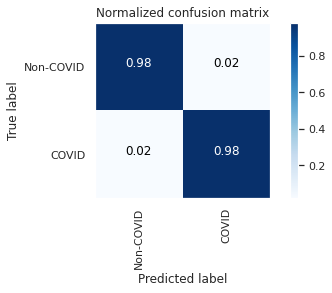

282/282 [==============================] - 51s 180ms/step - loss: 0.1615 - accuracy: 0.9501 - val_loss: 0.0719 - val_accuracy: 0.9792
Epoch 44/70
282/282 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9515
Epoch 00044: val_accuracy did not improve from 0.99167
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.176238


---------------------
| Balanced Accuracy  |
---------------------

    0.5


---------------------
|      Accuracy      |
---------------------

    0.08921161825726141


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       878
           1       0.09      1.00      0.16        86

    accuracy                           0.09       964
   macro avg       0.04      0.50      0.08       964
weighted avg       0.01      0.09      0.01       964

---------

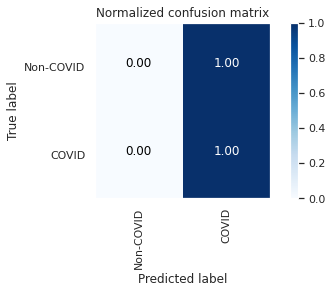

282/282 [==============================] - 51s 180ms/step - loss: 0.1419 - accuracy: 0.9515 - val_loss: 2.3929 - val_accuracy: 0.0854
Epoch 45/70
282/282 [==============================] - ETA: 0s - loss: 0.1957 - accuracy: 0.9240
Epoch 00045: val_accuracy improved from 0.99167 to 0.99271, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.170703


---------------------
| Balanced Accuracy  |
---------------------

    0.9802802352068656


---------------------
|      Accuracy      |
---------------------

    0.9927385892116183


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       878
           1       0.95      0.97      0.96        86

    accuracy                           0.99       964
   macro avg       0.98      0.98      0.98     

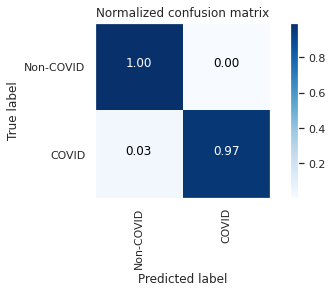

282/282 [==============================] - 52s 184ms/step - loss: 0.1957 - accuracy: 0.9240 - val_loss: 0.0449 - val_accuracy: 0.9927
Epoch 46/70
282/282 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9557
Epoch 00046: val_accuracy did not improve from 0.99271
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.181546


---------------------
| Balanced Accuracy  |
---------------------

    0.9826773322032103


---------------------
|      Accuracy      |
---------------------

    0.9875518672199171


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.89      0.98      0.93        86

    accuracy                           0.99       964
   macro avg       0.95      0.98      0.96       964
weighted avg       0.99      0.99      0.99       

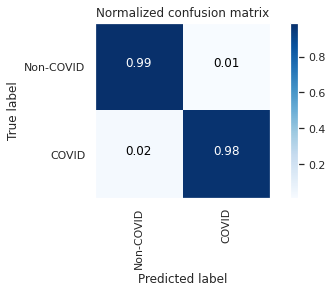

282/282 [==============================] - 51s 180ms/step - loss: 0.1276 - accuracy: 0.9557 - val_loss: 0.0333 - val_accuracy: 0.9875
Epoch 47/70
282/282 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9557
Epoch 00047: val_accuracy did not improve from 0.99271
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.163606


---------------------
| Balanced Accuracy  |
---------------------

    0.9890607617735869


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.90      0.99      0.94        86

    accuracy                           0.99       964
   macro avg       0.95      0.99      0.97       964
weighted avg       0.99      0.99      0.99       

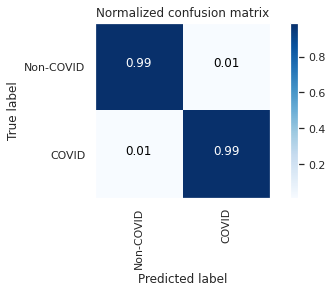

282/282 [==============================] - 51s 180ms/step - loss: 0.1471 - accuracy: 0.9557 - val_loss: 0.0401 - val_accuracy: 0.9896
Epoch 48/70
282/282 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9645
Epoch 00048: val_accuracy did not improve from 0.99271
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.192154


---------------------
| Balanced Accuracy  |
---------------------

    0.980399427875192


---------------------
|      Accuracy      |
---------------------

    0.983402489626556


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.86      0.98      0.91        86

    accuracy                           0.98       964
   macro avg       0.93      0.98      0.95       964
weighted avg       0.99      0.98      0.98       96

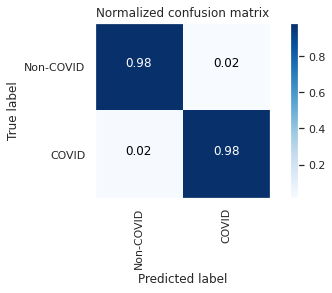

282/282 [==============================] - 51s 179ms/step - loss: 0.0994 - accuracy: 0.9645 - val_loss: 0.0519 - val_accuracy: 0.9833
Epoch 49/70
282/282 [==============================] - ETA: 0s - loss: 0.1118 - accuracy: 0.9601
Epoch 00049: val_accuracy improved from 0.99271 to 0.99375, saving model to Model/best_model_multiclass_128.h5
Predicting test data
61/61 [==============================] - 2s 36ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.228138


---------------------
| Balanced Accuracy  |
---------------------

    0.9860941886952376


---------------------
|      Accuracy      |
---------------------

    0.9937759336099585


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       878
           1       0.95      0.98      0.97        86

    accuracy                           0.99       964
   macro avg       0.98      0.99      0.98     

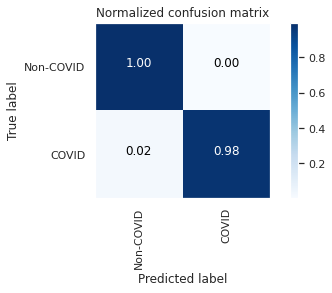

282/282 [==============================] - 52s 186ms/step - loss: 0.1118 - accuracy: 0.9601 - val_loss: 0.0285 - val_accuracy: 0.9937
Epoch 50/70
282/282 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9690
Epoch 00050: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.162601


---------------------
| Balanced Accuracy  |
---------------------

    0.9628383747417493


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.95      0.93      0.94        86

    accuracy                           0.99       964
   macro avg       0.97      0.96      0.97       964
weighted avg       0.99      0.99      0.99       

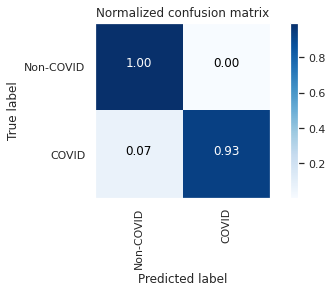

282/282 [==============================] - 51s 180ms/step - loss: 0.0983 - accuracy: 0.9690 - val_loss: 0.0372 - val_accuracy: 0.9896
Epoch 51/70
282/282 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9641
Epoch 00051: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.207884


---------------------
| Balanced Accuracy  |
---------------------

    0.9401520368702654


---------------------
|      Accuracy      |
---------------------

    0.9865145228215768


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.96      0.88      0.92        86

    accuracy                           0.99       964
   macro avg       0.98      0.94      0.96       964
weighted avg       0.99      0.99      0.99       

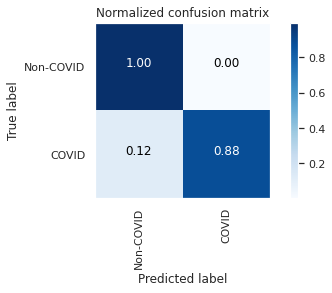

282/282 [==============================] - 51s 180ms/step - loss: 0.1070 - accuracy: 0.9641 - val_loss: 0.0469 - val_accuracy: 0.9875
Epoch 52/70
282/282 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9603
Epoch 00052: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.154301


---------------------
| Balanced Accuracy  |
---------------------

    0.9611299464957355


---------------------
|      Accuracy      |
---------------------

    0.9865145228215768


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       878
           1       0.92      0.93      0.92        86

    accuracy                           0.99       964
   macro avg       0.96      0.96      0.96       964
weighted avg       0.99      0.99      0.99       

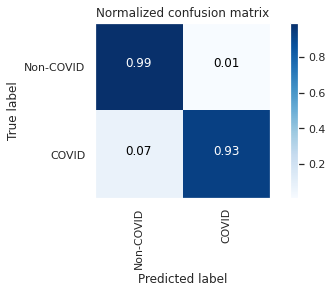

282/282 [==============================] - 51s 179ms/step - loss: 0.1046 - accuracy: 0.9603 - val_loss: 0.0582 - val_accuracy: 0.9865
Epoch 53/70
282/282 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9428
Epoch 00053: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.144957


---------------------
| Balanced Accuracy  |
---------------------

    0.9809689039571965


---------------------
|      Accuracy      |
---------------------

    0.9844398340248963


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.87      0.98      0.92        86

    accuracy                           0.98       964
   macro avg       0.93      0.98      0.95       964
weighted avg       0.99      0.98      0.98       

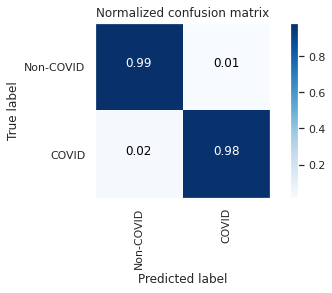

282/282 [==============================] - 51s 179ms/step - loss: 0.1336 - accuracy: 0.9428 - val_loss: 0.0379 - val_accuracy: 0.9844
Epoch 54/70
282/282 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9337
Epoch 00054: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.154343


---------------------
| Balanced Accuracy  |
---------------------

    0.9221407003231445


---------------------
|      Accuracy      |
---------------------

    0.9823651452282157


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.95      0.85      0.90        86

    accuracy                           0.98       964
   macro avg       0.97      0.92      0.94       964
weighted avg       0.98      0.98      0.98       

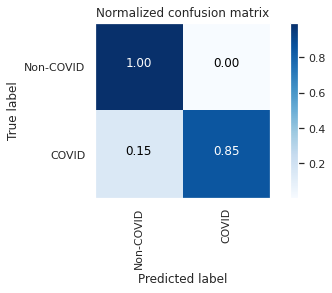

282/282 [==============================] - 50s 179ms/step - loss: 0.1720 - accuracy: 0.9337 - val_loss: 0.0468 - val_accuracy: 0.9823
Epoch 55/70
282/282 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9479
Epoch 00055: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.153788


---------------------
| Balanced Accuracy  |
---------------------

    0.9471049425226465


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.99      0.90      0.94        86

    accuracy                           0.99       964
   macro avg       0.99      0.95      0.97       964
weighted avg       0.99      0.99      0.99       

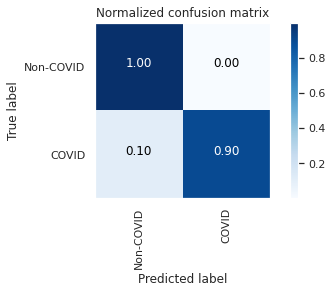

282/282 [==============================] - 50s 178ms/step - loss: 0.1239 - accuracy: 0.9479 - val_loss: 0.0275 - val_accuracy: 0.9896
Epoch 56/70
282/282 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9690
Epoch 00056: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.148716


---------------------
| Balanced Accuracy  |
---------------------

    0.9838162843672194


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.91      0.98      0.94        86

    accuracy                           0.99       964
   macro avg       0.96      0.98      0.97       964
weighted avg       0.99      0.99      0.99       

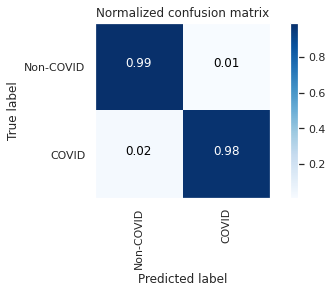

282/282 [==============================] - 50s 178ms/step - loss: 0.0854 - accuracy: 0.9690 - val_loss: 0.0339 - val_accuracy: 0.9896
Epoch 57/70
282/282 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9765
Epoch 00057: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.164325


---------------------
| Balanced Accuracy  |
---------------------

    0.9305239179954442


---------------------
|      Accuracy      |
---------------------

    0.8734439834024896


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.86      0.93       878
           1       0.41      1.00      0.59        86

    accuracy                           0.87       964
   macro avg       0.71      0.93      0.76       964
weighted avg       0.95      0.87      0.89       

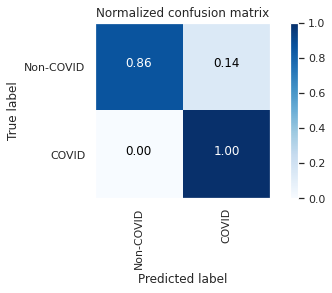

282/282 [==============================] - 51s 179ms/step - loss: 0.0781 - accuracy: 0.9765 - val_loss: 0.3040 - val_accuracy: 0.8729
Epoch 58/70
282/282 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9521
Epoch 00058: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.154416


---------------------
| Balanced Accuracy  |
---------------------

    0.9280076283307729


---------------------
|      Accuracy      |
---------------------

    0.8879668049792531


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.88      0.93       878
           1       0.44      0.98      0.61        86

    accuracy                           0.89       964
   macro avg       0.72      0.93      0.77       964
weighted avg       0.95      0.89      0.91       

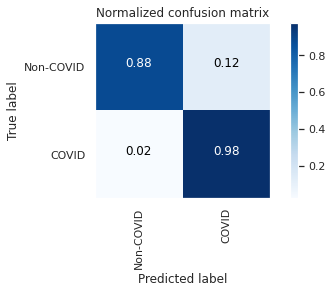

282/282 [==============================] - 50s 179ms/step - loss: 0.1306 - accuracy: 0.9521 - val_loss: 0.2364 - val_accuracy: 0.8875
Epoch 59/70
282/282 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9592
Epoch 00059: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.176816


---------------------
| Balanced Accuracy  |
---------------------

    0.7363325740318907


---------------------
|      Accuracy      |
---------------------

    0.5197095435684648


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.47      0.64       878
           1       0.16      1.00      0.27        86

    accuracy                           0.52       964
   macro avg       0.58      0.74      0.46       964
weighted avg       0.92      0.52      0.61       

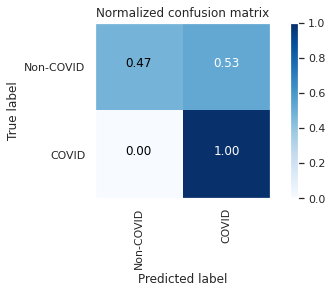

282/282 [==============================] - 50s 179ms/step - loss: 0.1211 - accuracy: 0.9592 - val_loss: 1.2988 - val_accuracy: 0.5177
Epoch 60/70
282/282 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9789
Epoch 00060: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.150255


---------------------
| Balanced Accuracy  |
---------------------

    0.8568363617100174


---------------------
|      Accuracy      |
---------------------

    0.9398340248962656


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       878
           1       0.64      0.76      0.69        86

    accuracy                           0.94       964
   macro avg       0.81      0.86      0.83       964
weighted avg       0.95      0.94      0.94       

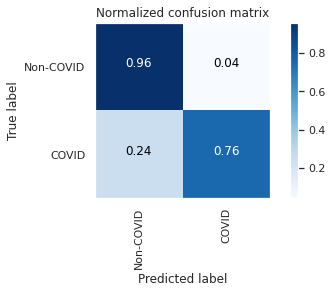

282/282 [==============================] - 50s 178ms/step - loss: 0.0767 - accuracy: 0.9789 - val_loss: 0.1816 - val_accuracy: 0.9396
Epoch 61/70
282/282 [==============================] - ETA: 0s - loss: 0.1177 - accuracy: 0.9617
Epoch 00061: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.144342


---------------------
| Balanced Accuracy  |
---------------------

    0.9634078508237538


---------------------
|      Accuracy      |
---------------------

    0.9906639004149378


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.96      0.93      0.95        86

    accuracy                           0.99       964
   macro avg       0.98      0.96      0.97       964
weighted avg       0.99      0.99      0.99       

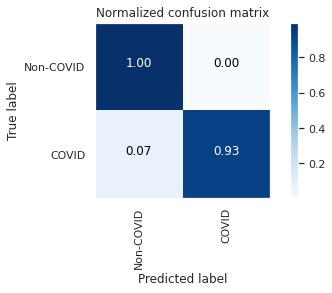

282/282 [==============================] - 50s 179ms/step - loss: 0.1177 - accuracy: 0.9617 - val_loss: 0.0281 - val_accuracy: 0.9917
Epoch 62/70
282/282 [==============================] - ETA: 0s - loss: 0.0860 - accuracy: 0.9736
Epoch 00062: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.143389


---------------------
| Balanced Accuracy  |
---------------------

    0.9855247126132329


---------------------
|      Accuracy      |
---------------------

    0.9927385892116183


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       878
           1       0.94      0.98      0.96        86

    accuracy                           0.99       964
   macro avg       0.97      0.99      0.98       964
weighted avg       0.99      0.99      0.99       

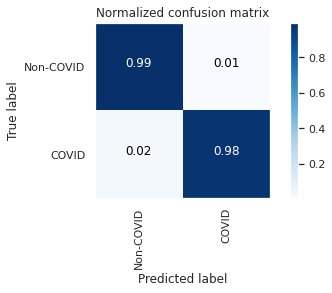

282/282 [==============================] - 50s 178ms/step - loss: 0.0860 - accuracy: 0.9736 - val_loss: 0.0228 - val_accuracy: 0.9927
Epoch 63/70
282/282 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9801
Epoch 00063: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.155906


---------------------
| Balanced Accuracy  |
---------------------

    0.9520448164432908


---------------------
|      Accuracy      |
---------------------

    0.9221991701244814


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       878
           1       0.53      0.99      0.69        86

    accuracy                           0.92       964
   macro avg       0.77      0.95      0.82       964
weighted avg       0.96      0.92      0.93       

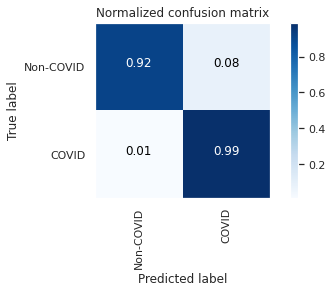

282/282 [==============================] - 50s 178ms/step - loss: 0.0702 - accuracy: 0.9801 - val_loss: 0.2461 - val_accuracy: 0.9219
Epoch 64/70
282/282 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9674
Epoch 00064: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.149341


---------------------
| Balanced Accuracy  |
---------------------

    0.9747046670551465


---------------------
|      Accuracy      |
---------------------

    0.9730290456431535


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       878
           1       0.78      0.98      0.87        86

    accuracy                           0.97       964
   macro avg       0.89      0.97      0.93       964
weighted avg       0.98      0.97      0.97       

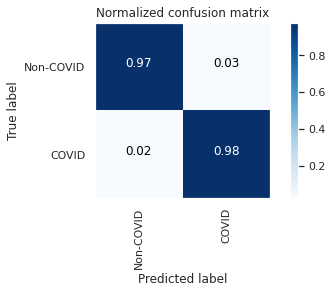

282/282 [==============================] - 50s 178ms/step - loss: 0.0962 - accuracy: 0.9674 - val_loss: 0.0949 - val_accuracy: 0.9729
Epoch 65/70
282/282 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9816
Epoch 00065: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.177580


---------------------
| Balanced Accuracy  |
---------------------

    0.9890607617735869


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       878
           1       0.90      0.99      0.94        86

    accuracy                           0.99       964
   macro avg       0.95      0.99      0.97       964
weighted avg       0.99      0.99      0.99       

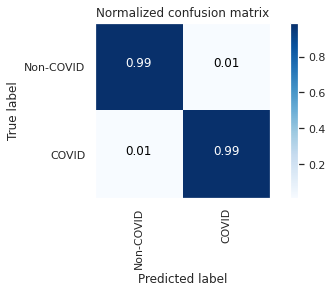

282/282 [==============================] - 50s 178ms/step - loss: 0.0672 - accuracy: 0.9816 - val_loss: 0.0399 - val_accuracy: 0.9896
Epoch 66/70
282/282 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9798
Epoch 00066: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.145028


---------------------
| Balanced Accuracy  |
---------------------

    0.9783599088838268


---------------------
|      Accuracy      |
---------------------

    0.9605809128630706


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       878
           1       0.69      1.00      0.82        86

    accuracy                           0.96       964
   macro avg       0.85      0.98      0.90       964
weighted avg       0.97      0.96      0.96       

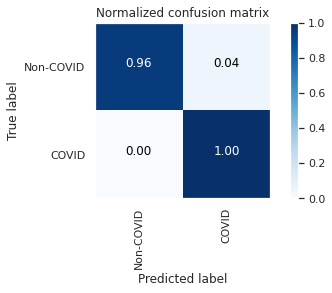

282/282 [==============================] - 50s 179ms/step - loss: 0.0689 - accuracy: 0.9798 - val_loss: 0.1012 - val_accuracy: 0.9604
Epoch 67/70
282/282 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9738
Epoch 00067: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 35ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.162174


---------------------
| Balanced Accuracy  |
---------------------

    0.9775520474651692


---------------------
|      Accuracy      |
---------------------

    0.9782157676348547


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       878
           1       0.82      0.98      0.89        86

    accuracy                           0.98       964
   macro avg       0.91      0.98      0.94       964
weighted avg       0.98      0.98      0.98       

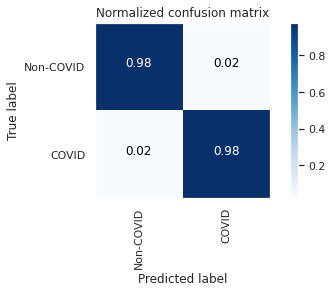

282/282 [==============================] - 50s 179ms/step - loss: 0.0893 - accuracy: 0.9738 - val_loss: 0.0705 - val_accuracy: 0.9781
Epoch 68/70
282/282 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9712
Epoch 00068: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.153128


---------------------
| Balanced Accuracy  |
---------------------

    0.9616994225777401


---------------------
|      Accuracy      |
---------------------

    0.9875518672199171


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       878
           1       0.93      0.93      0.93        86

    accuracy                           0.99       964
   macro avg       0.96      0.96      0.96       964
weighted avg       0.99      0.99      0.99       

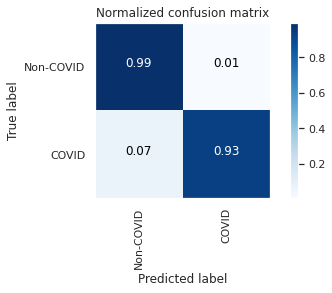

282/282 [==============================] - 50s 179ms/step - loss: 0.0878 - accuracy: 0.9712 - val_loss: 0.0276 - val_accuracy: 0.9875
Epoch 69/70
282/282 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9803
Epoch 00069: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.141245


---------------------
| Balanced Accuracy  |
---------------------

    0.9810880966255231


---------------------
|      Accuracy      |
---------------------

    0.975103734439834


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       878
           1       0.79      0.99      0.88        86

    accuracy                           0.98       964
   macro avg       0.89      0.98      0.93       964
weighted avg       0.98      0.98      0.98       9

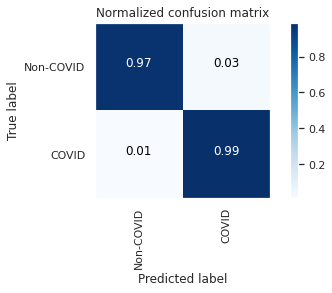

282/282 [==============================] - 51s 179ms/step - loss: 0.0618 - accuracy: 0.9803 - val_loss: 0.0926 - val_accuracy: 0.9750
Epoch 70/70
282/282 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9641
Epoch 00070: val_accuracy did not improve from 0.99375
Predicting test data
61/61 [==============================] - 2s 34ms/step
Done 
 

testing time(HH:MM:SS:ms) - 0:00:02.151299


---------------------
| Balanced Accuracy  |
---------------------

    0.9628383747417493


---------------------
|      Accuracy      |
---------------------

    0.9896265560165975


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       878
           1       0.95      0.93      0.94        86

    accuracy                           0.99       964
   macro avg       0.97      0.96      0.97       964
weighted avg       0.99      0.99      0.99       

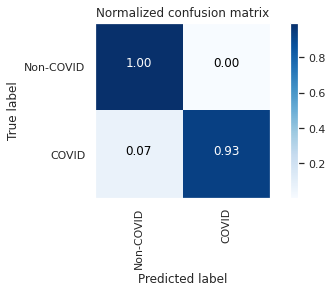

282/282 [==============================] - 50s 179ms/step - loss: 0.0935 - accuracy: 0.9641 - val_loss: 0.0410 - val_accuracy: 0.9896


In [ ]:
class_weights = {0: 0.5490387, 1: 5.59801489}
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_data) // train_generator.batch_size,
                              validation_data=val_generator,
                              validation_steps= len(test_data)// val_generator.batch_size, #change the val/test properly eventhough it doesnt affect the process
                              class_weight =class_weights,
                              epochs = 70,
                              callbacks = get_callbacks(),
                              verbose = 1
                              )

In [ ]:
preds=model.predict(val2_generator)
fpr, tpr, threshold = roc_curve(val_label, preds[:,1])


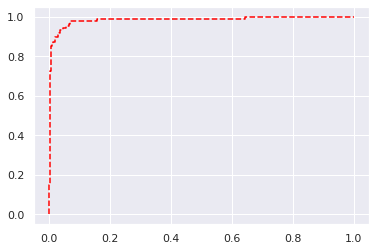

In [ ]:
plt.plot(fpr,tpr, linestyle='--',color='red',label='COVID VS Non-COVID')
plt.savefig('Binary ROC',dpi=300);


## **CONCLUSION**

The model in our project is built in order to classify different forms of pneumonia efficiently with identifying distinctive features. 

The multiclass model had 97% accuracy while predicting COVID alongside an accuracy of 98% person to predict healthy chest X-Rays.  

The multiclass model has balanced accuracy of 84.5%. 

The secondary sub-class model to predict just the COVID cases had an accuracy of 98% and an almost perfect prediction score while classifying healthy X-rays.

It is evident that using non-traditional convolution like depth_wise convolution with necessary call back functions increased the efficiency of our primary model.

Moreover, the model can be adapted to any field of study or analysis where identifying subtle feature is cumbersome. 